# Tarefa 3: Explorando o Capítulo 6 – "Deep Learning with PyTorch"

Este notebook explora conceitos fundamentais de otimização em deep learning, baseando-se no Capítulo 6 do livro Deep Learning with PyTorch Step-by-Step. O foco será em técnicas e ferramentas essenciais para o treinamento de modelos neurais de forma mais estável e eficiente. Os códigos utilizados são uma adaptação do repositório original dos livros que pode ser acessados [aqui](https://github.com/dvgodoy/PyTorchStepByStep)

# Bibliotecas utilizadas

In [121]:
# Importações para controle de aleatoriedade e cópia profunda
import random
import numpy as np
from copy import deepcopy

# Importações para visualização de dados
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

# Importações para manipulação de imagens e dados
import pandas as pd
from PIL import Image

# Importações de bibliotecas Scikit-Learn para aprendizado de máquina
from sklearn.linear_model import SGDClassifier
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss

# Importações do PyTorch para deep learning
import torch
import torch.nn as nn  # Módulos de redes neurais
import torch.nn.functional as F  # Operações funcionais (sem parâmetros)
import torch.optim as optim  # Algoritmos de otimização
from torch_lr_finder import LRFinder

# Utilitários do PyTorch para manipulação de datasets e loaders
from torch.utils.data import DataLoader, Dataset, random_split, WeightedRandomSampler, TensorDataset
import torchvision
from torchvision.datasets import ImageFolder
from torchvision.transforms import Compose, ToTensor, Normalize, ToPILImage, Resize
import torchvision.transforms as transforms

# Agendadores de taxa de aprendizado (learning rate schedulers)
from torch.optim.lr_scheduler import StepLR, ReduceLROnPlateau, MultiStepLR, CyclicLR, LambdaLR

# Utilitários para download de arquivos e manipulação de sistemas de arquivos
import requests
import zipfile
import os
import errno

In [2]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

C:\Users\elisa\AppData\Local\Temp\ipykernel_5092\82325636.py:1: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


In [3]:
try:
    import google.colab
    import requests
    url = 'https://raw.githubusercontent.com/dvgodoy/PyTorchStepByStep/master/config.py'
    r = requests.get(url, allow_redirects=True)
    open('config.py', 'wb').write(r.content)    
except ModuleNotFoundError:
    pass

from config import *
config_chapter6()
from plots.chapter6 import *

# Classe Architecture

A classe Architecture foi criada pelo professor Ivanovitch no [repositório](https://github.com/ivanovitchm/PPGEEC2318) da disciplina de Machine Learning para o Programa de Pós Graduação em Engenharia Elétrica e de Computação (PPGEEC) da UFRN. Ela é insipirada na classe StepByStep, usada pelo Daniel Godoy.

A classe Architecture é uma implementação modular e completa de uma pipeline de treinamento e validação de modelos no PyTorch. Durante o desenvolvimento do trabalho, vários módulos serão adicionados a ela.

In [4]:
class Architecture(object):
    def __init__(self, model, loss_fn, optimizer):
        # Aqui definimos os atributos da nossa classe.

        # Armazenamos os argumentos como atributos para uso posterior.
        self.model = model
        self.loss_fn = loss_fn
        self.optimizer = optimizer
        self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
        # Enviamos o modelo para o dispositivo especificado imediatamente.
        self.model.to(self.device)

        ## Esses atributos são definidos aqui, 
        #mas como não são informados na criação da classe, permanecem como None.
        self.train_loader = None
        self.val_loader = None

        # Esses atributos serão calculados internamente.
        self.losses = []
        self.val_losses = []
        self.total_epochs = 0

        # Cria a função de passo de treinamento para o modelo, a função de perda e o otimizador.
        # Observação: não há argumentos aqui! A função utiliza diretamente os atributos da classe.
        self.train_step_fn = self._make_train_step_fn()
        # Cria a função de passo de validação para o modelo e a função de perda.
        self.val_step_fn = self._make_val_step_fn()

        # Para propósitos de hooks
        self.handles = {}
        self.visualization = {}

    def to(self, device):
    # Este método permite ao usuário especificar um dispositivo diferente
    # Ele define o atributo correspondente (a ser usado depois nos mini-lotes)
    # e envia o modelo para o dispositivo especificado
        try:
            self.device = device
            self.model.to(self.device)
        except RuntimeError:
            self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
            print(f"Não foi possível enviar para {device}, enviando para {self.device} em vez disso.")
            self.model.to(self.device)

    def set_loaders(self, train_loader, val_loader=None):
    # Este método permite ao usuário definir qual `train_loader` (e opcionalmente `val_loader`) usar
    # Ambos os carregadores são atribuídos como atributos da classe
    # para que possam ser referenciados posteriormente
        self.train_loader = train_loader
        self.val_loader = val_loader

    def _make_train_step_fn(self):
        # Este método não precisa de argumentos... Ele pode referir-se
        # aos atributos: self.model, self.loss_fn e self.optimizer
    
        # Cria uma função que executa um passo no loop de treinamento
        def perform_train_step_fn(x, y):
            # Define o modelo no modo de TREINAMENTO
            self.model.train()
    
            # Passo 1 - Calcula a saída prevista do nosso modelo - forward pass
            yhat = self.model(x)
            # Passo 2 - Calcula a perda (loss)
            loss = self.loss_fn(yhat, y)
            # Passo 3 - Calcula os gradientes para os parâmetros
            loss.backward()
            # Passo 4 - Atualiza os parâmetros usando os gradientes e a taxa de aprendizado
            self.optimizer.step()
            self.optimizer.zero_grad()
    
            # Retorna a perda
            return loss.item()
    
        # Retorna a função que será chamada dentro do loop de treinamento
        return perform_train_step_fn

    def _make_val_step_fn(self):
        # Cria uma função que executa um passo no loop de validação
        def perform_val_step_fn(x, y):
            # Define o modelo no modo de AVALIAÇÃO
            self.model.eval()
    
            # Passo 1 - Calcula a saída prevista do nosso modelo - forward pass
            yhat = self.model(x)
            # Passo 2 - Calcula a perda (loss)
            loss = self.loss_fn(yhat, y)
            # Não é necessário realizar os Passos 3 e 4, pois não atualizamos parâmetros durante a avaliação
            return loss.item()
    
        return perform_val_step_fn

    def _mini_batch(self, validation=False):
        # O mini-lote pode ser usado com ambos os carregadores
        # O argumento `validation` define qual carregador e função
        # de passo correspondente serão usados
        if validation:
            data_loader = self.val_loader
            step_fn = self.val_step_fn
        else:
            data_loader = self.train_loader
            step_fn = self.train_step_fn
    
        if data_loader is None:
            return None
    
        # Uma vez definidos o carregador de dados e a função de passo, este é o mesmo
        # loop de mini-lotes que tínhamos antes
        mini_batch_losses = []
        for x_batch, y_batch in data_loader:
            x_batch = x_batch.to(self.device)
            y_batch = y_batch.to(self.device)
    
            mini_batch_loss = step_fn(x_batch, y_batch)
            mini_batch_losses.append(mini_batch_loss)
    
        loss = np.mean(mini_batch_losses)
        return loss

    # esta função foi atualizada nesta classe
    def set_seed(self, seed=42):
        # Define configurações para garantir a reprodutibilidade
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False
        torch.manual_seed(seed)
        np.random.seed(seed)
        random.seed(seed)
        try:
            self.train_loader.sampler.generator.manual_seed(seed)
        except AttributeError:
            pass

    def train(self, n_epochs, seed=42):
        # Para garantir a reprodutibilidade do processo de treinamento
        self.set_seed(seed)
    
        for epoch in range(n_epochs):
            # Mantém o controle do número de épocas
            # atualizando o atributo correspondente
            self.total_epochs += 1
    
            # Loop interno
            # Realiza o treinamento usando mini-lotes
            loss = self._mini_batch(validation=False)
            self.losses.append(loss)
    
            # VALIDAÇÃO
            # sem gradientes na validação!
            with torch.no_grad():
                # Realiza a avaliação usando mini-lotes
                val_loss = self._mini_batch(validation=True)
                self.val_losses.append(val_loss)

    def save_checkpoint(self, filename):
        # Cria um dicionário com todos os elementos para retomar o treinamento
        checkpoint = {
            'epoch': self.total_epochs,
            'model_state_dict': self.model.state_dict(),
            'optimizer_state_dict': self.optimizer.state_dict(),
            'loss': self.losses,
            'val_loss': self.val_losses
        }
    
        torch.save(checkpoint, filename)

    def load_checkpoint(self, filename):
        # Carrega o dicionário
        checkpoint = torch.load(filename)
    
        # Restaura o estado do modelo e do otimizador
        self.model.load_state_dict(checkpoint['model_state_dict'])
        self.optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    
        self.total_epochs = checkpoint['epoch']
        self.losses = checkpoint['loss']
        self.val_losses = checkpoint['val_loss']
    
        # Sempre usa o modo de TRAIN para retomar o treinamento
        self.model.train()

    def predict(self, x):
        # Define o modelo no modo de avaliação para realizar previsões
        self.model.eval()
        # Converte uma entrada Numpy para um tensor float
        x_tensor = torch.as_tensor(x).float()
        # Envia a entrada para o dispositivo e usa o modelo para fazer a previsão
        y_hat_tensor = self.model(x_tensor.to(self.device))
        # Define de volta para o modo de treinamento
        self.model.train()
        # Desanexa o tensor, traz para a CPU e converte de volta para Numpy
        return y_hat_tensor.detach().cpu().numpy()

    def count_parameters(self):
        # Retorna a contagem de parâmetros treináveis do modelo
        return sum(p.numel() for p in self.model.parameters() if p.requires_grad)

    def plot_losses(self):
        # Plota as perdas de treinamento e validação ao longo das épocas
        fig = plt.figure(figsize=(10, 4))
        plt.plot(self.losses, label='Perda de Treinamento', c='b')
        plt.plot(self.val_losses, label='Perda de Validação', c='r')
        plt.yscale('log')
        plt.xlabel('Épocas')
        plt.ylabel('Perda')
        plt.legend()
        plt.tight_layout()
        return fig
        
    def capture_gradients(self, layers_to_hook):
        # Captura os gradientes dos parâmetros especificados
        if not isinstance(layers_to_hook, list):
            layers_to_hook = [layers_to_hook]
    
        modules = list(self.model.named_modules())
        self._gradients = {}
    
        def make_log_fn(name, parm_id):
            def log_fn(grad):
                # Armazena os gradientes na estrutura de dicionário correspondente
                self._gradients[name][parm_id].append(grad.tolist())
                return None
            return log_fn
    
        for name, layer in self.model.named_modules():
            if name in layers_to_hook:
                self._gradients.update({name: {}})
                for parm_id, p in layer.named_parameters():
                    if p.requires_grad:
                        self._gradients[name].update({parm_id: []})
                        log_fn = make_log_fn(name, parm_id)
                        self.handles[f'{name}.{parm_id}.grad'] = p.register_hook(log_fn)
        return
    

    @staticmethod
    def _visualize_tensors(axs, x, y=None, yhat=None, layer_name='', title=None):
        # Visualiza tensores como imagens
        # O número de imagens corresponde ao número de subplots em uma linha
        n_images = len(axs)
        # Obtém os valores mínimo e máximo para escalar o grayscale
        minv, maxv = np.min(x[:n_images]), np.max(x[:n_images])
        # Para cada imagem
        for j, image in enumerate(x[:n_images]):
            ax = axs[j]
            # Define o título, rótulos e remove os ticks
            if title is not None:
                ax.set_title(f'{title} #{j}', fontsize=12)
            shp = np.atleast_2d(image).shape
            ax.set_ylabel(
                f'{layer_name}\n{shp[0]}x{shp[1]}',
                rotation=0, labelpad=40
            )
            xlabel1 = '' if y is None else f'\nRótulo: {y[j]}'
            xlabel2 = '' if yhat is None else f'\nPrevisto: {yhat[j]}'
            xlabel = f'{xlabel1}{xlabel2}'
            if len(xlabel):
                ax.set_xlabel(xlabel, fontsize=12)
            ax.set_xticks([])
            ax.set_yticks([])
    
            # Plota os pesos como uma imagem
            ax.imshow(
                np.atleast_2d(image.squeeze()),
                cmap='gray',
                vmin=minv,
                vmax=maxv
            )
        return

    def visualize_filters(self, layer_name, **kwargs):
        try:
            # Obtém o objeto da camada do modelo
            layer = self.model
            for name in layer_name.split('.'):
                layer = getattr(layer, name)
            # Apenas considera filtros de convoluções 2D
            if isinstance(layer, nn.Conv2d):
                # Obtém as informações dos pesos
                weights = layer.weight.data.cpu().numpy()
                # weights -> (filtros (saída), canais (entrada), H, W)
                n_filters, n_channels, _, _ = weights.shape
    
                # Cria a figura
                size = (2 * n_channels + 2, 2 * n_filters)
                fig, axes = plt.subplots(n_filters, n_channels, figsize=size)
                axes = np.atleast_2d(axes)
                axes = axes.reshape(n_filters, n_channels)
                # Para cada filtro (saída)
                for i in range(n_filters):
                    Architecture._visualize_tensors(
                        axes[i, :],
                        weights[i],
                        layer_name=f'Filtro #{i}',
                        title='Canal'
                    )
    
                for ax in axes.flat:
                    ax.label_outer()
    
                fig.tight_layout()
                return fig
        except AttributeError:
            return

    def attach_hooks(self, layers_to_hook, hook_fn=None):
        # Limpa quaisquer valores anteriores
        self.visualization = {}
        # Cria o dicionário para mapear objetos de camada para seus nomes
        modules = list(self.model.named_modules())
        layer_names = {layer: name for name, layer in modules[1:]}
    
        if hook_fn is None:
            # Função hook a ser anexada ao forward pass
            def hook_fn(layer, inputs, outputs):
                # Obtém o nome da camada
                name = layer_names[layer]
                # Desanexa os valores da saída
                values = outputs.detach().cpu().numpy()
                # Concatena os resultados se a função hook for chamada múltiplas vezes
                # Exemplo: previsões em vários mini-batches
                if self.visualization[name] is None:
                    self.visualization[name] = values
                else:
                    self.visualization[name] = np.concatenate([self.visualization[name], values])
    
        for name, layer in modules:
            # Se a camada estiver na lista especificada
            if name in layers_to_hook:
                # Inicializa a chave correspondente no dicionário
                self.visualization[name] = None
                # Registra o hook do forward e armazena o handle em outro dicionário
                self.handles[name] = layer.register_forward_hook(hook_fn)

    def remove_hooks(self):
        # Percorre todos os hooks e os remove
        for handle in self.handles.values():
            handle.remove()
        # Limpa o dicionário, já que todos os hooks foram removidos
        self.handles = {}
    
    def visualize_outputs(self, layers, n_images=10, y=None, yhat=None):
        # Filtra as camadas disponíveis na visualização
        layers = filter(lambda l: l in self.visualization.keys(), layers)
        layers = list(layers)
        shapes = [self.visualization[layer].shape for layer in layers]
        n_rows = [shape[1] if len(shape) == 4 else 1 for shape in shapes]
        total_rows = np.sum(n_rows)
    
        # Cria subplots com base no número de imagens e camadas
        fig, axes = plt.subplots(total_rows, n_images,
                                 figsize=(1.5 * n_images, 1.5 * total_rows))
        axes = np.atleast_2d(axes).reshape(total_rows, n_images)
    
        # Itera pelas camadas, com uma camada por linha de subplots
        row = 0
        for i, layer in enumerate(layers):
            start_row = row
            # Obtém os mapas de características produzidos pela camada
            output = self.visualization[layer]
    
            is_vector = len(output.shape) == 2
    
            for j in range(n_rows[i]):
                Architecture._visualize_tensors(
                    axes[row, :],
                    output if is_vector else output[:, j].squeeze(),
                    y,
                    yhat,
                    layer_name=layers[i] if is_vector else f'{layers[i]}\nfil#{row-start_row}',
                    title='Imagem' if (row == 0) else None
                )
                row += 1
    
        for ax in axes.flat:
            ax.label_outer()
    
        plt.tight_layout()
        return fig
    
    def correct(self, x, y, threshold=.5):
        self.model.eval()
        yhat = self.model(x.to(self.device))
        y = y.to(self.device)
        self.model.train()
    
        # Obtém o tamanho do batch e o número de classes (1, se for binário)
        n_samples, n_dims = yhat.shape
        if n_dims > 1:
            # Para classificação multiclasse, a maior probabilidade vence
            _, predicted = torch.max(yhat, 1)
        else:
            n_dims += 1
            # Para classificação binária, verifica se a última camada é sigmoid
            if isinstance(self.model, nn.Sequential) and isinstance(self.model[-1], nn.Sigmoid):
                predicted = (yhat > threshold).long()
            else:
                predicted = (F.sigmoid(yhat) > threshold).long()
    
        # Conta quantos exemplos foram classificados corretamente por classe
        result = []
        for c in range(n_dims):
            n_class = (y == c).sum().item()
            n_correct = (predicted[y == c] == c).sum().item()
            result.append((n_correct, n_class))
        return torch.tensor(result)
    
    @staticmethod
    def loader_apply(loader, func, reduce='sum'):
        # Aplica uma função para cada batch do loader
        results = [func(x, y) for i, (x, y) in enumerate(loader)]
        results = torch.stack(results, axis=0)
    
        # Reduz os resultados (soma ou média)
        if reduce == 'sum':
            results = results.sum(axis=0)
        elif reduce == 'mean':
            results = results.float().mean(axis=0)
    
        return results
    
    @staticmethod
    def statistics_per_channel(images, labels):
        # Obtém estatísticas (média e desvio padrão) por canal
        n_samples, n_channels, n_height, n_weight = images.size()
        flatten_per_channel = images.reshape(n_samples, n_channels, -1)
    
        means = flatten_per_channel.mean(axis=2)
        stds = flatten_per_channel.std(axis=2)
    
        sum_means = means.sum(axis=0)
        sum_stds = stds.sum(axis=0)
        n_samples = torch.tensor([n_samples] * n_channels).float()
    
        return torch.stack([n_samples, sum_means, sum_stds], axis=0)
    
    @staticmethod
    def make_normalizer(loader):
        # Cria normalizador baseado nas estatísticas por canal
        total_samples, total_means, total_stds = Architecture.loader_apply(loader, Architecture.statistics_per_channel)
        norm_mean = total_means / total_samples
        norm_std = total_stds / total_samples
        return Normalize(mean=norm_mean, std=norm_std)
    
    def lr_range_test(self, data_loader, end_lr, num_iter=100, step_mode='exp', alpha=0.05, ax=None):
        # Realiza o teste de intervalo de taxa de aprendizado
        previous_states = {'model': deepcopy(self.model.state_dict()), 'optimizer': deepcopy(self.optimizer.state_dict())}
        start_lr = self.optimizer.state_dict()['param_groups'][0]['lr']
    
        lr_fn = make_lr_fn(start_lr, end_lr, num_iter)
        scheduler = LambdaLR(self.optimizer, lr_lambda=lr_fn)
    
        tracking = {'loss': [], 'lr': []}
        iteration = 0
    
        while (iteration < num_iter):
            for x_batch, y_batch in data_loader:
                x_batch = x_batch.to(self.device)
                y_batch = y_batch.to(self.device)
                yhat = self.model(x_batch)
                loss = self.loss_fn(yhat, y_batch)
                loss.backward()
    
                tracking['lr'].append(scheduler.get_last_lr()[0])
                if iteration == 0:
                    tracking['loss'].append(loss.item())
                else:
                    prev_loss = tracking['loss'][-1]
                    smoothed_loss = alpha * loss.item() + (1 - alpha) * prev_loss
                    tracking['loss'].append(smoothed_loss)
    
                iteration += 1
                if iteration == num_iter:
                    break
    
                self.optimizer.step()
                scheduler.step()
                self.optimizer.zero_grad()
    
        self.optimizer.load_state_dict(previous_states['optimizer'])
        self.model.load_state_dict(previous_states['model'])
    
        if ax is None:
            fig, ax = plt.subplots(1, 1, figsize=(6, 4))
        else:
            fig = ax.get_figure()
        ax.plot(tracking['lr'], tracking['loss'])
        if step_mode == 'exp':
            ax.set_xscale('log')
        ax.set_xlabel('Taxa de Aprendizado')
        ax.set_ylabel('Perda')
        fig.tight_layout()
        return tracking, fig
    
    def set_optimizer(self, optimizer):
        # Define o otimizador
        self.optimizer = optimizer

# Importando os dados

Grande parte do capítulo 6 do livro utiliza o dataset [Rock Paper Scissors](https://laurencemoroney.com/datasets.html#rock-paper-scissors-dataset), criado por Laurence Moroney. Pedra, Papel e Tesoura contém imagens de diversas mãos, de diferentes raças, idades e gêneros, posicionadas nas formas de Pedra, Papel ou Tesoura e rotuladas de acordo. Moroney criou essas imagens utilizando técnicas de CGI como um experimento para verificar se um modelo treinado em um conjunto de dados baseado em CGI poderia classificar imagens reais. Todas essas imagens possuem um fundo branco liso. Cada imagem tem dimensões de 300×300 pixels em cores de 24 bits.

In [7]:
def download_rps(localfolder=''):
    filenames = ['rps.zip', 'rps-test-set.zip']
    for filename in filenames:
        try:
            os.mkdir(f'{localfolder}{filename[:-4]}')

            localfile = f'{localfolder}{filename}'
            # url = 'https://storage.googleapis.com/laurencemoroney-blog.appspot.com/{}'
            # Updated from TFDS URL at
            # https://github.com/tensorflow/datasets/blob/master/tensorflow_datasets/datasets/rock_paper_scissors/rock_paper_scissors_dataset_builder.py
            url = 'https://storage.googleapis.com/download.tensorflow.org/data/{}'
            r = requests.get(url.format(filename), allow_redirects=True)
            open(localfile, 'wb').write(r.content)
            with zipfile.ZipFile(localfile, 'r') as zip_ref:
                zip_ref.extractall(localfolder)
        except OSError as e:
            if e.errno != errno.EEXIST:
                raise
            else:
                print(f'{filename[:-4]} folder already exists!')
     

In [8]:
download_rps()

rps folder already exists!
rps-test-set folder already exists!


# Preparação dos dados

As imagens são redimensionadas para 28x28 pixels utilizando a função Resize do torchvision.transforms. Isso reduz as dimensões das imagens originais para o tamanho apropriado para modelos que trabalham com entradas de menor resolução.

A transformação ToTensor converte as imagens em tensores PyTorch e normaliza os valores dos pixels para estarem no intervalo de [0, 1] (a partir de valores originais entre [0, 255]).

As imagens são automaticamente transformadas para o modelo de cor RGB pelo carregador de imagens do PIL (Pillow), o que significa que elas terão três canais de cores (Red, Green, Blue). Nesse processo, o canal alfa (transparência) das imagens originais é perdido.

A classe ImageFolder organiza automaticamente as imagens no diretório rps em classes baseadas na estrutura de pastas. Cada subpasta em rps é tratada como uma classe diferente, e todas as imagens dentro de cada subpasta são atribuídas a essa classe.

In [9]:
# Transformação das imagens
temp_transform = Compose([Resize(28), ToTensor()])

# Criação do conjunto de dados
temp_dataset = ImageFolder(root='rps', transform=temp_transform)

Vamos criar um DataLoader para o conjunto de dados temp_dataset com um tamanho de lote (batch_size) de 16 amostras por iteração. O DataLoader facilita o carregamento de dados em mini-lotes para o treinamento de modelos, permitindo a iteração eficiente sobre o conjunto de dados.

In [10]:
temp_loader = DataLoader(temp_dataset, batch_size=16)

next(iter(temp_loader)) obtém o primeiro lote de imagens (first_images) e rótulos (first_labels) do DataLoader criado anteriormente.

In [11]:
first_images, first_labels = next(iter(temp_loader))

A célula abaixo calcula estatísticas por canal, como a média e o desvio padrão, a partir das imagens e rótulos extraídos.
Essas estatísticas podem ser úteis para normalizar os dados durante o pré-processamento.

In [12]:
Architecture.statistics_per_channel(first_images, first_labels)

tensor([[16.0000, 16.0000, 16.0000],
        [13.8748, 13.3048, 13.1962],
        [ 3.0507,  3.8268,  3.9754]])

Architecture.loader_apply(temp_loader, Architecture.statistics_per_channel) aplica a função statistics_per_channel a cada mini-lote de dados no temp_loader.

A função loader_apply percorre todo o DataLoader e calcula estatísticas como média e desvio padrão por canal, acumulando os resultados.

In [13]:
results = Architecture.loader_apply(temp_loader, Architecture.statistics_per_channel)
results

tensor([[2520.0000, 2520.0000, 2520.0000],
        [2142.5356, 2070.0806, 2045.1444],
        [ 526.3025,  633.0677,  669.9556]])

results armazena as estatísticas calculadas e a célula imprime esses valores, que incluem o número de amostras, a média e o desvio padrão dos pixels por canal.

A função Architecture.make_normalizer(temp_loader) calcula a média e o desvio padrão de cada canal (R, G, B ou outros canais) a partir de todo o conjunto de dados presente no temp_loader.

Utilizando as estatísticas calculadas, a função retorna uma instância da transformação Normalize do PyTorch, que padroniza os valores dos pixels

In [14]:
normalizer = Architecture.make_normalizer(temp_loader)
normalizer

Normalize(mean=tensor([0.8502, 0.8215, 0.8116]), std=tensor([0.2089, 0.2512, 0.2659]))

Vamos fazer a definição do pré-processamento das imagens

In [15]:
composer = Compose([
    Resize(28),  # Redimensiona as imagens para 28x28
    ToTensor(),  # Converte as imagens para tensores PyTorch
    Normalize(mean=[0.5], std=[0.5])  # Normaliza os valores de pixel
])

In [16]:
# Carregamento dos datasets de treinamento e validação
train_data = ImageFolder(root='rps', transform=composer)
val_data = ImageFolder(root='rps-test-set', transform=composer)

In [17]:
# Criação dos DataLoaders para o treinamento e validação
train_loader = DataLoader(train_data, batch_size=16, shuffle=True)
val_loader = DataLoader(val_data, batch_size=16)

O próximo passo é a definição de um modelo de dropout simples. O dropout ajuda na regularização, removendo aleatoriamente conexões durante o treinamento. Aqui, testamos a diferença de comportamento entre modo de treinamento e validação

In [18]:
dropping_model = nn.Sequential(nn.Dropout(p=0.5))

In [19]:
# Geração de pontos de teste
spaced_points = torch.linspace(0.1, 1.1, 11)
torch.manual_seed(44)

In [20]:
# Saída com dropout durante o treinamento
dropping_model.train()
output_train = dropping_model(spaced_points)
F.linear(output_train, weight=torch.ones(11), bias=torch.tensor(0))

tensor(9.4000)

In [21]:
# Saída com dropout durante a validação
dropping_model.eval()
output_eval = dropping_model(spaced_points)
F.linear(output_eval, weight=torch.ones(11), bias=torch.tensor(0))

tensor(6.6000)

In [22]:
# Análise estatística do efeito do dropout
# Realizando múltiplas amostragens para demonstrar o impacto do dropout
p = 0.5
torch.manual_seed(17)
distrib_outputs = torch.tensor([
    F.linear(F.dropout(spaced_points, p=p), weight=torch.ones(11), bias=torch.tensor(0))
    for _ in range(1000)
])

In [23]:
# Definição de uma arquitetura de CNN customizada
class CNN2(nn.Module):
    def __init__(self, n_feature, p=0.0):
        super(CNN2, self).__init__()
        self.n_feature = n_feature
        self.p = p

        # Camadas convolucionais
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=n_feature, kernel_size=3)
        self.conv2 = nn.Conv2d(in_channels=n_feature, out_channels=n_feature, kernel_size=3)

        # Camadas totalmente conectadas (FC layers)
        self.fc1 = nn.Linear(n_feature * 5 * 5, 50)
        self.fc2 = nn.Linear(50, 3)

        # Camada de dropout para regularização
        self.drop = nn.Dropout(self.p)

    def featurizer(self, x):
        # Extração de características com camadas convolucionais
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, kernel_size=2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, kernel_size=2)
        x = nn.Flatten()(x)
        return x

    def classifier(self, x):
        # Camadas totalmente conectadas com dropout
        if self.p > 0:
            x = self.drop(x)
        x = F.relu(self.fc1(x))
        if self.p > 0:
            x = self.drop(x)
        x = self.fc2(x)
        return x

    def forward(self, x):
        x = self.featurizer(x)
        x = self.classifier(x)
        return x

In [24]:
# Configuração do modelo com dropout
torch.manual_seed(13)
model_cnn2 = CNN2(n_feature=5, p=0.3)

In [25]:
# Definição da função de perda e otimizador
multi_loss_fn = nn.CrossEntropyLoss(reduction='mean')
optimizer_cnn2 = optim.Adam(model_cnn2.parameters(), lr=3e-4)

In [26]:
# Definição de um wrapper de arquitetura para facilitar o treino e validação
arch_cnn2 = Architecture(model_cnn2, multi_loss_fn, optimizer_cnn2)
arch_cnn2.set_loaders(train_loader, val_loader)
arch_cnn2.train(10)

In [27]:
# Avaliação do modelo
Architecture.loader_apply(val_loader, arch_cnn2.correct)
Architecture.loader_apply(val_loader, arch_cnn2.correct).sum(axis=0)

tensor([302, 372])

In [28]:
# Treinamento de um modelo idêntico sem dropout para comparar resultados
torch.manual_seed(13)
model_cnn2_nodrop = CNN2(n_feature=5, p=0.0)
multi_loss_fn = nn.CrossEntropyLoss(reduction='mean')
optimizer_cnn2_nodrop = optim.Adam(model_cnn2_nodrop.parameters(), lr=3e-4)
arch_cnn2_nodrop = Architecture(model_cnn2_nodrop, multi_loss_fn, optimizer_cnn2_nodrop)
arch_cnn2_nodrop.set_loaders(train_loader, val_loader)
arch_cnn2_nodrop.train(10)

# Taxa de aprendizagem (LR)

Na aprendizagem automática, a taxa de aprendizagem é um hiperparâmetro crucial que determina o tamanho do passo em cada iteração, enquanto se move em direção a um mínimo da função de perda. É um conceito fundamental para treinar modelos de forma eficiente e eficaz, especialmente em algoritmos de otimização como a descida de gradiente. 

Primeiro, precisamos definir os limites para o teste (start_lr e end_lr) e o número de iterações (num_iter) para mover de um valor ao outro. Além disso, podemos escolher como fazer os incrementos: de forma linear ou exponencial. Vamos construir uma função de ordem superior que receba todos esses argumentos e retorne outra função, que devolve o fator multiplicador com base no número atual de iterações.

In [29]:
def make_lr_fn(start_lr, end_lr, num_iter, step_mode='exp'):
    if step_mode == 'linear':
        factor = (end_lr / start_lr - 1) / num_iter
        def lr_fn(iteration):
            return 1 + iteration * factor
    else:
        factor = (np.log(end_lr) - np.log(start_lr)) / num_iter
        def lr_fn(iteration):
            return np.exp(factor)**iteration
    return lr_fn

* start_lr: Taxa de aprendizagem inicial.
* end_lr: Taxa de aprendizagem final.
* num_iter: Número total de iterações (ou épocas) para o ajuste da taxa de aprendizagem.
* step_mode: Modo de ajuste da taxa de aprendizagem (linear ou exp)

A função retorna um scheduler (agendador) de taxa de aprendizagem.

In [31]:
# Configuração inicial para a função de taxa de aprendizado
start_lr = 0.01
end_lr = 0.1
num_iter = 10

In [32]:
# Função para gerar a sequência de taxas de aprendizado
lr_fn = make_lr_fn(start_lr, end_lr, num_iter, step_mode='exp')

In [33]:
# Configurando modelo, otimizador e agendador dummy
dummy_model = CNN2(n_feature=5, p=0.3)
dummy_optimizer = optim.Adam(dummy_model.parameters(), lr=start_lr)
dummy_scheduler = LambdaLR(dummy_optimizer, lr_lambda=lr_fn)

In [34]:
# Passos iniciais do otimizador e do agendador
dummy_optimizer.step()
dummy_scheduler.step()

In [35]:
# Configuração para o teste de faixa de taxa de aprendizado
torch.manual_seed(13)
new_model = CNN2(n_feature=5, p=0.3)
multi_loss_fn = nn.CrossEntropyLoss(reduction='mean')
new_optimizer = optim.Adam(new_model.parameters(), lr=3e-4)

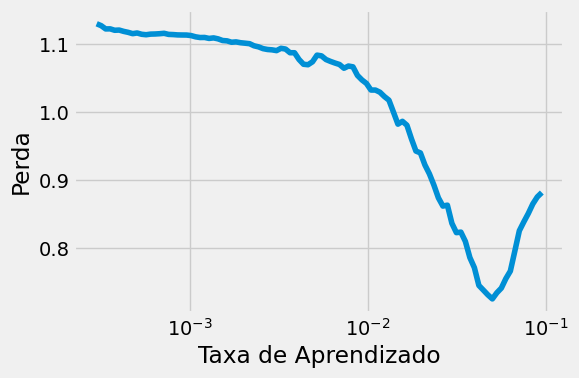

In [36]:
# Realizando o teste de faixa de taxa de aprendizado
arch_new = Architecture(new_model, multi_loss_fn, new_optimizer)
tracking, fig = arch_new.lr_range_test(train_loader, end_lr=1e-1, num_iter=100)

In [37]:
# Identificando a melhor taxa de aprendizado
min_loss = min(tracking['loss'])
min_loss_index = tracking['loss'].index(min_loss)
corresponding_lr = tracking['lr'][min_loss_index]

In [38]:
# Configurando novo otimizador e realizando treinamento
new_optimizer = optim.Adam(new_model.parameters(), lr=0.005)
arch_new.set_optimizer(new_optimizer)
arch_new.set_loaders(train_loader, val_loader)
arch_new.train(10)

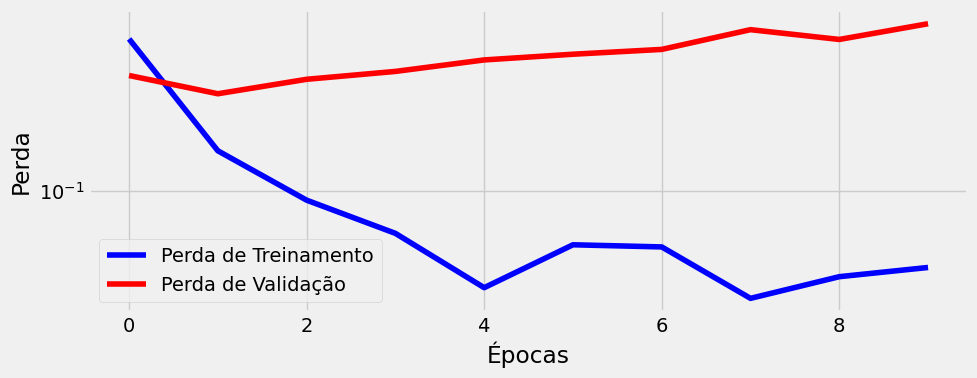

In [39]:
# Gerando gráfico de perdas
fig = arch_new.plot_losses()

Em vez de chamar uma função diretamente, precisamos criar uma instância da classe LRFinder primeiro, usando os objetos típicos de configuração do modelo (modelo, otimizador, função de perda e o dispositivo). Em seguida, podemos usar o método range_test(), fornecendo argumentos familiares: um data loader (carregador de dados), o limite superior para a taxa de aprendizagem e o número de iterações. O método reset() restaura os estados originais tanto do modelo quanto do otimizador.

In [40]:
# Configurando novamente o modelo para usar o LR Finder
torch.manual_seed(11)
new_model = CNN2(n_feature=5, p=0.3)
multi_loss_fn = nn.CrossEntropyLoss(reduction='mean')
new_optimizer = optim.Adam(new_model.parameters(), lr=3e-4)
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [41]:
# Inicializando e rodando o LR Finder
lr_finder = LRFinder(new_model, new_optimizer, multi_loss_fn, device=device)
lr_finder.range_test(train_loader, end_lr=1e-1, num_iter=100)

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:05<00:00, 16.73it/s]

Learning rate search finished. See the graph with {finder_name}.plot()


LR suggestion: steepest gradient
Suggested LR: 2.17E-02


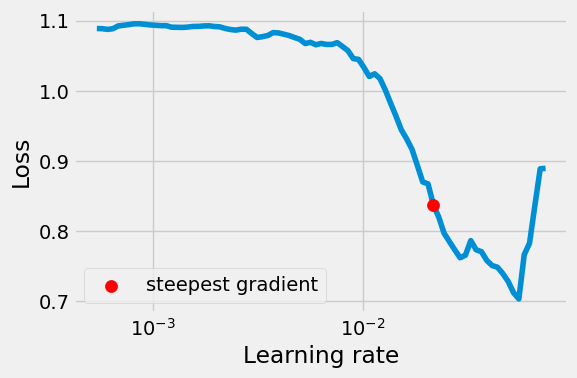

In [42]:
# Gerando o gráfico de taxa de aprendizado
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
lr_finder.plot(ax=ax, log_lr=True)
fig.tight_layout()
lr_finder.reset()

In [43]:
# Simulação de custos para diferentes configurações de aprendizado
epochs = list(range(30))
cost_eta_1 = [0.6 / (i + 1)**0.5 for i in epochs]
cost_eta_2 = [0.4 / (i + 1)**0.7 for i in epochs]
cost_eta_3 = [0.8 + 0.2 * (-1)**i for i in epochs]

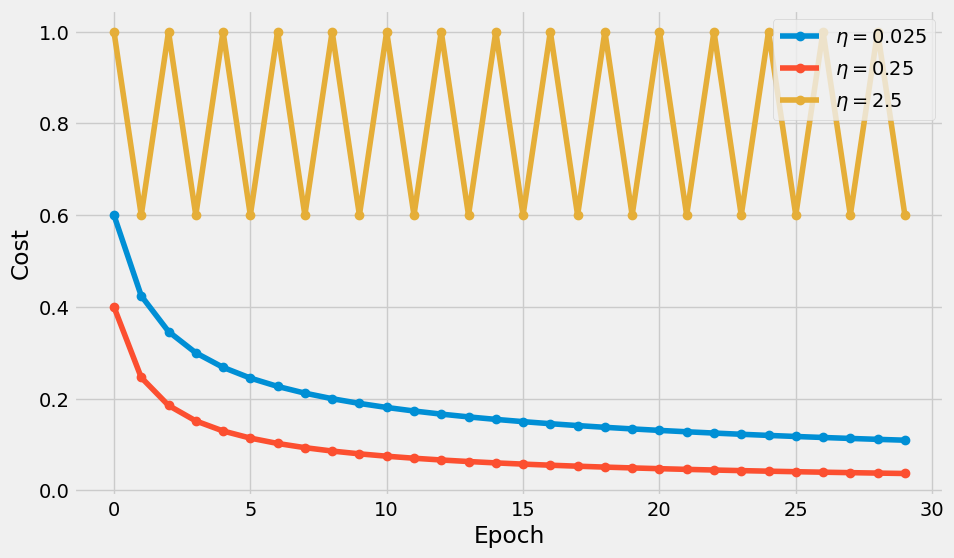

In [46]:
# Criando o gráfico de custo por época
plt.figure(figsize=(10, 6))
plt.plot(epochs, cost_eta_1, 'o-', label=r'$\eta = 0.025$')
plt.plot(epochs, cost_eta_2, 'o-', label=r'$\eta = 0.25$')
plt.plot(epochs, cost_eta_3, 'o-', label=r'$\eta = 2.5$')

# Personalizando e exibindo o gráfico
plt.xlabel('Epoch')
plt.ylabel('Cost')
plt.legend()
plt.grid(True)
plt.show()

# EWMA


Dentro das possibilidades do learning rate a gente tem o Adaptive Learning Rate (Taxa de aprendizagem adaptativa), que como o nome sugere, é dinamicamente ajustada com base na performance e no gradiente da função custo. 

Você já ouviu falar do otimizador Adam, certo? Ele é um bom exemplo do Adaptive Learning Rate! ele começa com a taxa de aprendizado fornecida como argumento, mas adapta essa taxa ao longo do treinamento, ajustando-a de forma diferente para cada parâmetro do modelo. Ou mais ou menos isso, na verdade, o Adam não adapta diretamente a taxa de aprendizado — ele adapta os gradientes. Mas, como a atualização dos parâmetros é feita pela multiplicação da taxa de aprendizado e do gradiente, essa diferença se torna irrelevante na prática.

O Adam combina as características de dois outros otimizadores:

- **SGD com momentum:** Ele usa uma média móvel dos gradientes em vez dos gradientes diretamente (isso é conhecido como o **primeiro momento** em termos estatísticos);
- **RMSProp:** Ele escala os gradientes usando uma média móvel dos gradientes ao quadrado (o **segundo momento**, ou variância não centralizada).

Complicou? Bom, vamos conhecer um pouco sobre essa média móvel, ou melhor ainda, sobre a média móvel exponencialmente ponderada, e depois a gente se aprofunda melhor no Adam.

De maneira bem simples, EWMA é uma média móvel exponencialmente ponderada, e como o nome sugere, ela é diferente da média simples… Ela fornece um peso maior para valores mais recentes, se destacando na suavização dos dados. No Machine Learning, usamos o EWMA para suavizar os gradientes durante o treinamento. Pode parecer simples, mas impede que gradientes muito instáveis atrapalhem a convergência do modelo. Essa abordagem é especialmente útil em algoritmos de otimização como o Adam, que dependem de cálculos de médias móveis para ajustar a taxa de aprendizado de forma adaptativa.

Visualizar o comportamento dos gradientes suavizados com EWMA pode ajudar a entender melhor a estabilidade do treinamento e identificar possíveis problemas, como gradientes explosivos ou o desaparecimento de gradientes.

Vamos entender o EWMA comparando com a média móvel simples (MA). 

In [58]:
# Função para calcular a média móvel simples
def moving_average(data, N):
    """
    Calcula a média móvel simples (MA) para uma lista de dados.

    Parâmetros:
        data (list): Dados de entrada.
        N (int): Número de períodos para calcular a média móvel.

    Retorna:
        list: Média móvel calculada para os dados.
    """
    return [sum(data[i:i+N])/N for i in range(len(data)-N+1)]


A Média Móvel Simples (MA) calcula a média aritmética de um conjunto de valores ao longo de um período fixo. Ela é usada para suavizar flutuações nos dados e destacar tendências.

In [59]:
# Função para calcular a idade média de uma média móvel
def average_age_ma(N):
    """
    Calcula a idade média da média móvel (MA).

    Parâmetros:
        N (int): Número de períodos da média móvel.

    Retorna:
        float: Idade média calculada.
    """
    return (N + 1) / 2

Por sua vez, a Média Móvel Exponencialmente Ponderada (EWMA) atribui pesos exponenciais decrescentes aos valores passados, dando mais importância aos valores mais recentes.

In [60]:
# Função para visualizar a diferença entre EWMA e MA
def figure15(alpha=1/3, periods=5, steps=10):
    """
    Gera um gráfico comparando os pesos do EWMA e da MA.

    Parâmetros:
        alpha (float): Fator de suavização para EWMA.
        periods (int): Número de períodos para MA.
        steps (int): Número de passos para visualização.

    Retorna:
        matplotlib.figure.Figure: Figura gerada.
    """
    t = np.arange(1, steps+1)
    fig, ax = plt.subplots(1, 1, figsize=(6, 4))
    ax.bar(t-1, alpha*(1-alpha)**(t-1), label='EWMA')
    ax.bar(t-1, [1/periods]*periods + [0]*(10-periods), color='r', alpha=.3, label='MA')
    ax.set_xticks(t-1)
    ax.grid(False)
    ax.set_xlabel('Defasagem')
    ax.set_ylabel('Peso')
    ax.set_title('EWMA vs MA')
    ax.legend()
    fig.tight_layout()
    return fig


alpha é um fator de suavização, que varia entre 0 e 1 e controla a importância dos valores mais recentes. 

Quando alpha está próximo de 1: os valores mais recentes recebem mais peso, resultando em uma curva mais sensível a mudanças. Quando alpha está próximo de 0: os valores antigos ainda influenciam bastante, resultando em uma curva mais suave e lenta para reagir a mudanças.

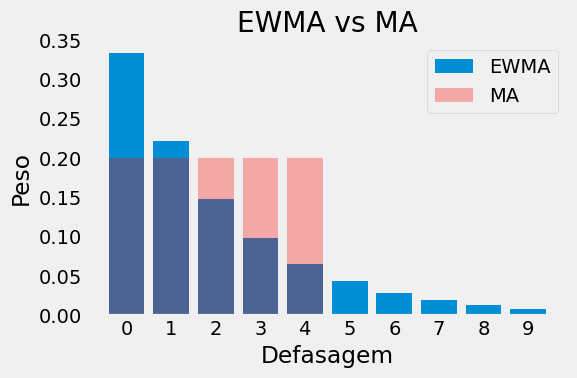

In [61]:
# Visualização da diferença entre EWMA e MA
fig = figure15()

O gráfico compara a Média Móvel Exponencialmente Ponderada (EWMA) e a Média Móvel Simples (MA) usando 5 períodos. O eixo Y diz respeito ao peso atribuido a cada ponto de dado anterior ao calcular a média, enquanto o eixo X representa o número de passos (ou períodos) anterires ao ponto atual (quanto maior o lag, mas distante no passado está o dado).

Pela imagem a gente analisa o seguinte: a EWMA atribui pesos decrescentes exponencialmente ao longo do tempo. Os valores mais recentes têm mais influência no cálculo da média, enquanto os valores mais antigos têm menos peso. Isso quer dizer que a EWMA reage mais rapidamente a mudanças recentes nos dados, pois dá mais peso ao ponto atual.

Já a MA, atribui pesos iguais para os últimos 5 períodos. Assim, os últimos 5 pontos contribuem igualmente para o cálculo da média, enquanto os mais antigos não têm influência. Ou seja, quando comparado a EWMA, A MA reage mais lentamente e suaviza os dados de forma mais uniforme, sem priorizar os valores recentes.

Essa diferença é importante no contexto de otimização de redes neurais, pois a EWMA ajuda a estabilizar o treinamento ao suavizar os gradientes de forma mais dinâmica.

In [62]:
# Função para calcular o EWMA
def EWMA(past_value, current_value, alpha):
    """
    Calcula o EWMA para um dado ponto.

    Parâmetros:
        past_value (float): Valor anterior.
        current_value (float): Valor atual.
        alpha (float): Fator de suavização.

    Retorna:
        float: Valor suavizado.
    """
    return (1 - alpha) * past_value + alpha * current_value

In [63]:
# Função para calcular a série EWMA
def calc_ewma(values, period):
    """
    Calcula a série de EWMA para uma lista de valores.

    Parâmetros:
        values (list): Dados de entrada.
        period (int): Período para calcular o EWMA.

    Retorna:
        numpy.array: Série suavizada com EWMA.
    """
    alpha = 2 / (period + 1)
    result = []
    for v in values:
        try:
            prev_value = result[-1]
        except IndexError:
            prev_value = 0

        new_value = EWMA(prev_value, v, alpha)
        result.append(new_value)
    return np.array(result)

O Bias-Corrected EWMA (Média Móvel Exponencialmente Ponderada Corrigida para Viés) é uma variação da EWMA que corrige o viés introduzido no início do cálculo de uma média móvel exponencialmente ponderada.

Quando o cálculo de uma EWMA começa, os primeiros valores podem estar enviesados para valores menores, pois a série temporal ainda não acumulou informações suficientes. Isso ocorre porque o cálculo depende fortemente dos valores iniciais e a média tende a subestimar os valores reais no início. Para corrigir esse viés, multiplicamos o termo da EWMA por um fator de correção de viés.  Essa correção é especialmente usada em algoritmos como o Adam, para melhorar a estabilidade no início do treinamento, já que o otimizador utiliza EWMA tanto para os gradientes quanto para os gradientes ao quadrado.

In [64]:
# Função para corrigir o viés do EWMA
def correction(averaged_value, beta, steps):
    """
    Corrige o viés do EWMA.

    Parâmetros:
        averaged_value (float): Valor suavizado.
        beta (float): Fator de decaimento.
        steps (int): Número de passos.

    Retorna:
        float: Valor corrigido.
    """
    return averaged_value / (1 - (beta ** steps))

In [65]:
# Função para calcular o EWMA corrigido
def calc_corrected_ewma(values, period):
    """
    Calcula a série de EWMA corrigida.

    Parâmetros:
        values (list): Dados de entrada.
        period (int): Período para calcular o EWMA.

    Retorna:
        numpy.array: Série suavizada e corrigida com EWMA.
    """
    ewma = calc_ewma(values, period)

    alpha = 2 / (period + 1)
    beta = 1 - alpha

    result = []
    for step, v in enumerate(ewma):
        adj_value = correction(v, beta, step + 1)
        result.append(adj_value)

    return np.array(result)

In [66]:
# Função para comparar MA e EWMA
def ma_vs_ewma(values, periods=19):
    """
    Gera um gráfico comparando MA, EWMA e EWMA corrigido.

    Parâmetros:
        values (list): Dados de entrada.
        periods (int): Número de períodos para calcular a MA.

    Retorna:
        matplotlib.figure.Figure: Figura gerada.
    """
    ma19 = pd.Series(values).rolling(min_periods=0, window=periods).mean()
    fig, ax = plt.subplots(1, 1, figsize=(6, 4))
    ax.plot(values, c='k', label='Temperaturas')
    ax.plot(ma19, c='k', linestyle='--', label='MA')
    ax.plot(calc_ewma(values, periods), c='r', linestyle='--', label='EWMA)')
    ax.plot(calc_corrected_ewma(values, periods), c='r', linestyle='-', label='EWMA Corrigido')
    ax.set_title('MA vs EWMA')
    ax.set_ylabel('Temperatura')
    ax.set_xlabel('Dias')
    ax.legend(fontsize=12)
    fig.tight_layout()
    return fig

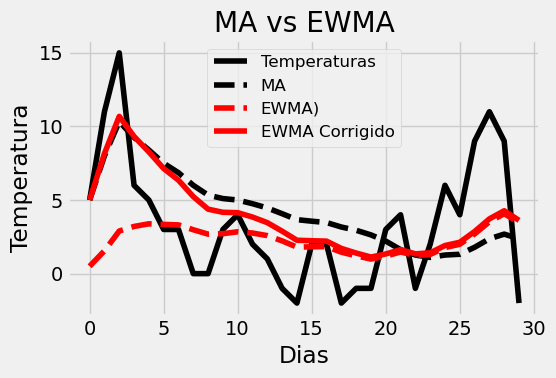

In [67]:
# Dados de temperatura e visualização do gráfico
temperatures = np.array([5, 11, 15, 6, 5, 3, 3, 0, 0, 3, 4, 2, 1,
    -1, -2, 2, 2, -2, -1, -1, 3, 4, -1, 2, 6, 4, 9, 11, 9, -2])
fig = ma_vs_ewma(temperatures, periods=19)

A Figura acima mostra um exemplo prático da comparação da Média Móvel Simples (MA), da EWMA e a EWMA com correção do viés (Bias). Como esperado, a EWMA sem correção (linha vermelha tracejada) está bem distante no início, enquanto a média móvel regular (linha preta tracejada) acompanha os valores reais de forma muito mais próxima. No entanto, a EWMA corrigida faz um ótimo trabalho ao acompanhar os valores reais desde o início. De fato, após 19 dias, as duas EWMAs são quase indistinguíveis.

# Adam 

Já sabemos que o otimizador Adam utiliza a média móvel exponencialmente ponderada (EWMA) para ajustar os gradientes durante o treinamento, vamos dar uma olhada em como isso acontece.

Para cada parâmetro do modelo, o Adam calcula **duas EWMA**:

1. **EWMA dos gradientes**  – para suavizar os gradientes.
2. **EWMA do quadrado dos gradientes** – para escalonar os gradientes e controlar a variância.

Essas médias são corrigidas para viés no início do trei.namentoa).

Vamos falar de seis argumentos para o Adam no PyTorch, a maioria já mencionado por aqui.

- Primeiro o `params` , que são os parâmetros do modelo que o otimizador irá atualizar durante o treinamento.  Normalmente, é passado como `model.parameters()` ao inicializar o otimizador.
- o `lr`(learning rate), a  taxa de aprendizado, que controla o tamanho dos passos na direção do gradiente durante a atualização dos parâmetros. 
Valor padrão: `1e-3` (0.001).
- `betas`, uma tupla contendo os valores `beta1` e `beta2`, usados para calcular as EWMAs dos gradientes e dos gradientes ao quadrado.
    - Valores padrão: `(0.9, 0.999)`
        - `beta1`: controla a suavização dos gradientes.
        - `beta2`: controla a suavização dos gradientes ao quadrado (para a escala).
- **`eps`(epsilon), u**m pequeno valor constante (normalmente `1e-8`) adicionado ao denominador para evitar divisão por zero e garantir estabilidade numérica.

Esses quatro argumentos são os principais para o funcionamento básico do Adam, enquanto `weight_decay` e `amsgrad` são argumentos opcionais que controlam regularização e variações do algoritmo.

- `weight_decay`  vai adicionar uma regularização L2 para prevenir overfitting, reduzindo o valor dos pesos ao longo do tempo.
- `amsgrad` é uma variante do Adam que ajusta a forma de calcular o gradiente adaptado para maior estabilidade.

Esses ajustes tornam o Adam mais robusto e controlado, especialmente em treinamentos de redes neurais profundas.

In [78]:
optimizer = optim.Adam(model_cnn2.parameters(), lr=0.0125, betas=(0.9, 0.999), eps=1e-8)

# Visualizing Adapted Gradients


A partir de agora, e até o final da seção "Learning Rates", usaremos APENAS o conjunto de dados de regressão linear simples para ilustrar os efeitos de diferentes parâmetros na minimização da perda. Voltaremos ao conjunto de dados "Rock Paper Scissors" na seção "Putting It All Together".

Primeiro, geramos novamente os pontos de dados e executamos a etapa típica de preparação dos dados (construção do conjunto de dados, divisão e criação de data loaders):

In [69]:
# Configurações iniciais
true_b = 1  # Intercepto verdadeiro
true_w = 2  # Coeficiente angular verdadeiro
N = 100  # Número de amostras

In [70]:
# Gerar dados sintéticos
np.random.seed(42)
x = np.random.rand(N, 1)
y = true_b + true_w * x + (0.1 * np.random.randn(N, 1))

In [71]:
idx = np.arange(N)
np.random.shuffle(idx)

In [72]:
# Dividir os índices em conjunto de treino e validação
idx = np.arange(N)
np.random.shuffle(idx)
train_idx = idx[:int(N * 0.8)]
val_idx = idx[int(N * 0.8):]

In [73]:
# Separar os dados de treino e validação
x_train, y_train = x[train_idx], y[train_idx]
x_val, y_val = x[val_idx], y[val_idx]

Vamos ilustrar os efeitos de diferentes parâmetros na minimização da perda! Primeiro precisamos fazer o tratamento usual dos dados: construção do dataset, divisão e criação de data loaders).

In [74]:
# Configurações do PyTorch
torch.manual_seed(13)
x_tensor = torch.as_tensor(x).float()
y_tensor = torch.as_tensor(y).float()

In [75]:
# Criar dataset com todos os pontos de dados
dataset = TensorDataset(x_tensor, y_tensor)

In [76]:
# Dividir o dataset
ratio = 0.8
n_total = len(dataset)
n_train = int(n_total * ratio)
n_val = n_total - n_train
train_data, val_data = random_split(dataset, [n_train, n_val])

In [77]:
# Criar DataLoaders para treino e validação
train_loader = DataLoader(dataset=train_data, batch_size=16, shuffle=True)
val_loader = DataLoader(dataset=val_data, batch_size=16)

Depois, revisamos a configuração do modelo e alteramos o otimizador de SGD para Adam:

In [78]:
# Criar o modelo de regressão linear
torch.manual_seed(42)
model = nn.Sequential()
model.add_module('linear', nn.Linear(1, 1))
optimizer = optim.Adam(model.parameters(), lr=0.1)
loss_fn = nn.MSELoss(reduction='mean')

Estaríamos prontos para usar a classe Architecture para treinar nosso modelo, se não fosse por um pequeno detalhe: ainda não temos uma maneira de registrar os gradientes. Então, vamos resolver isso adicionando mais um método à nossa classe: capture_gradients(). Assim como o método attach_hooks(), ele receberá uma lista de camadas que devem ser monitoradas quanto aos valores dos seus gradientes.

In [79]:
# Arquitetura de treinamento
sbs_adam = Architecture(model, loss_fn, optimizer)
sbs_adam.set_loaders(train_loader)

In [80]:
# Função para capturar gradientes
def capture_gradients(self, layers_to_hook):
    if not isinstance(layers_to_hook, list):
        layers_to_hook = [layers_to_hook]

    self._gradients = {}

    def make_log_fn(name, parm_id):
        def log_fn(grad):
            self._gradients[name][parm_id].append(grad.tolist())
            return None
        return log_fn

    for name, layer in self.model.named_modules():
        if name in layers_to_hook:
            self._gradients.update({name: {}})
            for parm_id, p in layer.named_parameters():
                if p.requires_grad:
                    self._gradients[name].update({parm_id: []})
                    log_fn = make_log_fn(name, parm_id)
                    self.handles[f'{name}.{parm_id}.grad'] = p.register_hook(log_fn)
    return
setattr(Architecture, 'capture_gradients', capture_gradients)

Para cada camada monitorada, a função percorre os parâmetros e, para aqueles que requerem gradientes, criará uma função de registro (log_fn()) e registrará um gancho (hook) para ela no tensor correspondente ao parâmetro.

A função de registro simplesmente adiciona os gradientes a uma lista na entrada do dicionário correspondente ao nome da camada e do parâmetro. O próprio dicionário, _gradients, é um atributo da classe (que será criado dentro do método construtor, mas estamos configurando manualmente usando setattr por enquanto). 

Ao final do treinamento, teremos coletado duas séries de 50 gradientes cada (cada época possui cinco mini-lotes), cada série correspondendo a um parâmetro da camada linear (peso e viés), ambos armazenados no atributo _gradients da nossa classe Architecture .

Agora que tal comparar com o SGD? Temos discutido como a atualização do parâmetro é diferente, mas agora é hora de mostrar como isso afeta o treinamento do modelo. Vamos visualizar o caminho percorrido por cada otimizador para trazer os dois parâmetros (mais próximos) de seus valores ótimos. Vamos criar um outro método para isso.

O novo método, chamado de capture_parameters(), funciona de forma semelhante ao capture_gradients(). Ele mantém um dicionário (parameters) como atributo da classe e registra hooks para as camadas cujos parâmetros gostaríamos de registrar. A função de registro simplesmente percorre os parâmetros de uma camada e adiciona seus valores à entrada correspondente no dicionário.

In [81]:
# Função para capturar parâmetros
def capture_parameters(self, layers_to_hook):
    if not isinstance(layers_to_hook, list):
        layers_to_hook = [layers_to_hook]

    self._parameters = {}

    def fw_hook_fn(layer, inputs, outputs):
        name = layer_names[layer]
        for parm_id, parameter in layer.named_parameters():
            self._parameters[name][parm_id].append(parameter.tolist())

    self.attach_hooks(layers_to_hook, fw_hook_fn)
    return
setattr(Architecture, 'capture_parameters', capture_parameters)

Vamos criar duas instâncias de Architecture, cada uma usando um otimizador diferente, configurá-las para capturar parâmetros e treiná-las por dez épocas. Os parâmetros capturados (viés e peso) desenharão os seguintes caminhos (o ponto vermelho representa seus valores ótimos).

In [82]:
# Treinar o modelo e capturar gradientes
sbs_adam.capture_gradients('linear')
sbs_adam.train(10)
sbs_adam.remove_hooks()

In [83]:
# Processar os gradientes
gradients = np.array(sbs_adam._gradients['linear']['weight']).squeeze()
corrected_gradients = calc_corrected_ewma(gradients, 19)
corrected_sq_gradients = calc_corrected_ewma(np.power(gradients, 2), 1999)
adapted_gradients = corrected_gradients / (np.sqrt(corrected_sq_gradients) + 1e-8)

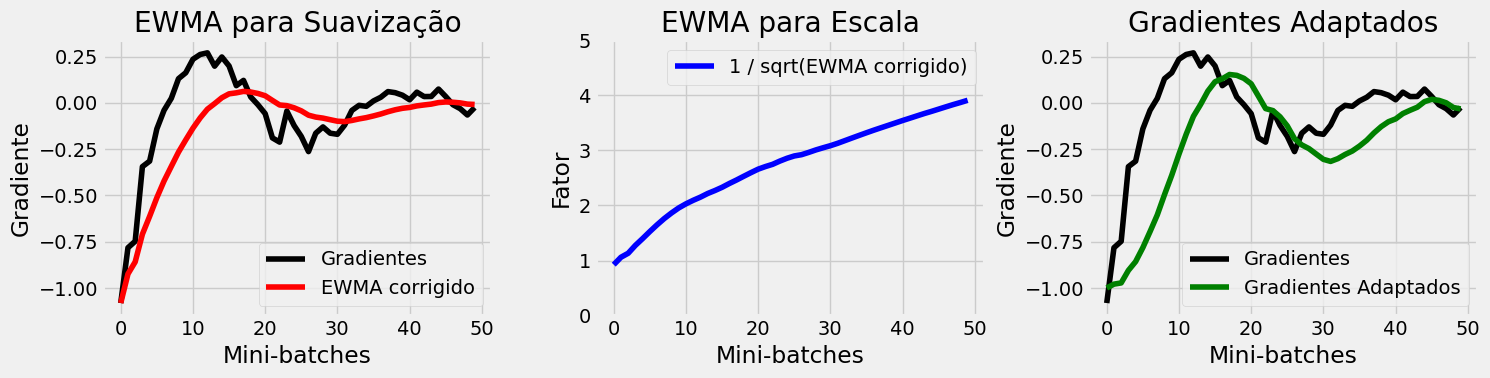

In [84]:
# Função para visualização dos gradientes
def figure17(gradients, corrected_gradients, corrected_sq_gradients, adapted_gradients):
    fig, axes = plt.subplots(1, 3, figsize=(15, 4))

    # EWMA para suavização
    axes[0].plot(gradients, label='Gradientes', color='black')
    axes[0].plot(corrected_gradients, label='EWMA corrigido', color='red')
    axes[0].set_title('EWMA para Suavização')
    axes[0].set_xlabel('Mini-batches')
    axes[0].set_ylabel('Gradiente')
    axes[0].legend()

    # EWMA para escala
    axes[1].plot((1/np.sqrt(corrected_sq_gradients)), color='blue', label='1 / sqrt(EWMA corrigido)')
    axes[1].set_title('EWMA para Escala')
    axes[1].set_xlabel('Mini-batches')
    axes[1].set_ylabel('Fator')
    axes[1].legend()
    axes[1].set_ylim([0, 5])

    # Gradientes adaptados
    axes[2].plot(gradients, label='Gradientes', color='black')
    axes[2].plot(adapted_gradients, label='Gradientes Adaptados', color='green')
    axes[2].set_title('Gradientes Adaptados')
    axes[2].set_xlabel('Mini-batches')
    axes[2].set_ylabel('Gradiente')
    axes[2].legend()

    plt.tight_layout()
    plt.show()
    return fig

# Exibir o gráfico
fig = figure17(gradients, corrected_gradients, corrected_sq_gradients, adapted_gradients)

No gráfico à esquerda, vemos que o EWMA corrigido por viés dos gradientes (em vermelho) suaviza os gradientes. No centro, o EWMA corrigido por viés dos gradientes ao quadrado é usado para escalar os gradientes suavizados. À direita, ambos os EWMAs são combinados para calcular os gradientes adaptados.

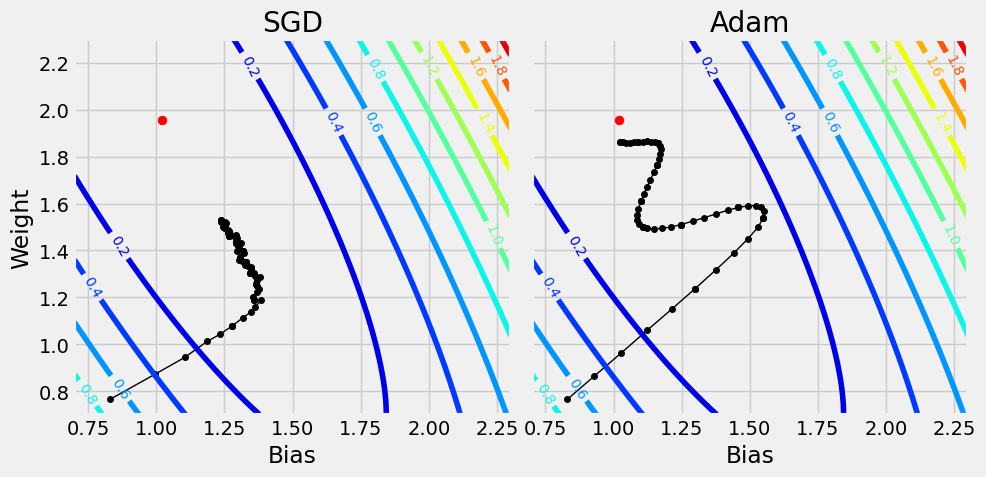

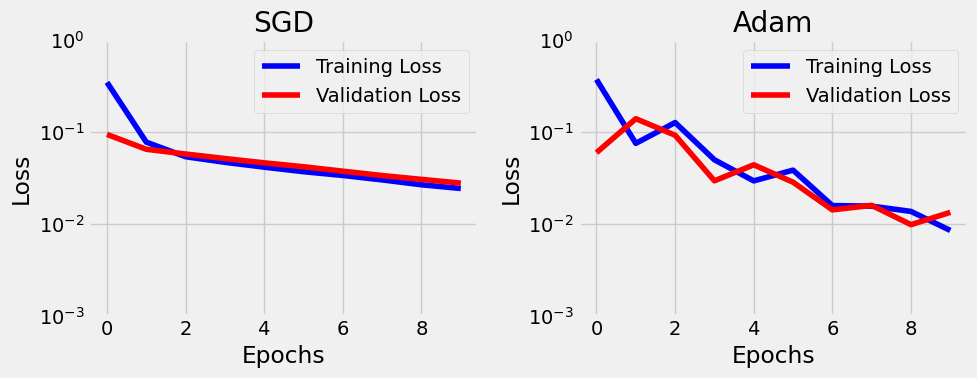

In [85]:
# Comparação de otimizadores
def compare_and_visualize_optimizers():
    torch.manual_seed(42)
    model = nn.Sequential()
    model.add_module('linear', nn.Linear(1, 1))
    loss_fn = nn.MSELoss(reduction='mean')

    optimizers = {
        'SGD': {'class': optim.SGD, 'parms': {'lr': 0.1}},
        'Adam': {'class': optim.Adam, 'parms': {'lr': 0.1}}
    }

    results = compare_optimizers(model, loss_fn, optimizers, train_loader, val_loader, n_epochs=10)
    b, w, bs, ws, all_losses = contour_data(x_tensor, y_tensor)

    fig_paths = plot_paths(results, b, w, bs, ws, all_losses)
    fig_losses = plot_losses(results)
    return fig_paths, fig_losses

fig_paths, fig_losses = compare_and_visualize_optimizers()

# Stochastic Gradient Descent (SGD)

É um algoritmo de otimização que atualiza os pesos de um modelo utilizando uma amostra aleatória dos dados de treinamento.  O SGD do PyTorch tem alguns argumentos:

- **params**: parâmetros do modelo
- **lr**: taxa de aprendizado
- **weight_decay**: penalidade L2
- **momentum**: fator de momentum, o próprio argumento beta do SGD.
- **dampening**: fator de amortecimento para o momentum
- **nesterov**: habilita o momentum de Nesterov, que é uma versão mais inteligente do momentum regular.

In [90]:
# Configurando a semente para reprodutibilidade
torch.manual_seed(42)

# Definindo o modelo sequencial com uma camada linear
model = nn.Sequential()
model.add_module('linear', nn.Linear(1, 1))  # Camada com 1 entrada e 1 saída

# Definindo a função de perda como o erro médio quadrático (MSE)
loss_fn = nn.MSELoss(reduction='mean')

In [91]:
# Configurando os otimizadores para comparação
# Inclui SGD puro, SGD com Momentum e SGD com Nesterov Momentum
optimizers = {
    'SGD': {'class': optim.SGD, 'parms': {'lr': 0.1}},  # Gradiente Descendente Simples
    'SGD + Momentum': {'class': optim.SGD, 'parms': {'lr': 0.1, 'momentum': 0.9}},  # Com Momentum
    'SGD + Nesterov': {'class': optim.SGD, 'parms': {'lr': 0.1, 'momentum': 0.9, 'nesterov': True}}  # Nesterov Momentum
}

In [92]:
# Comparando os otimizadores com os dados de treinamento e validação
# n_epochs define o número de épocas para treinamento
results = compare_optimizers(model, loss_fn, optimizers, train_loader, val_loader, n_epochs=10)

# Gerando os dados de contorno para visualização do espaço de perda
b, w, bs, ws, all_losses = contour_data(x_tensor, y_tensor)


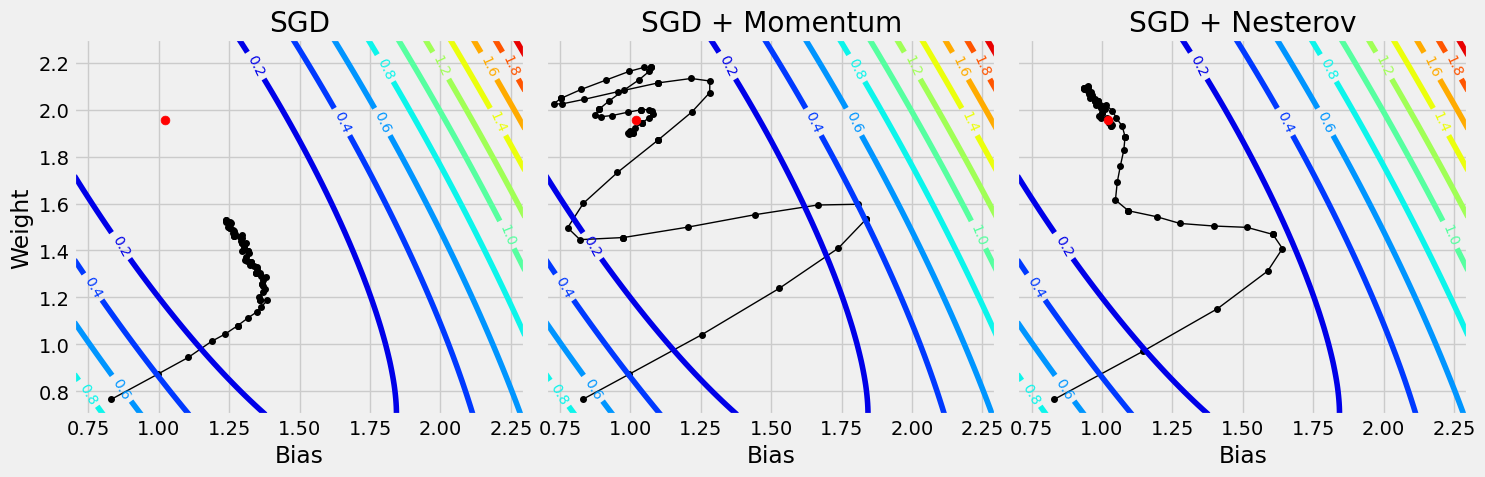

In [93]:
# Gerando o gráfico de trajetórias no espaço de parâmetros (bias e peso)
fig_paths = plot_paths(results, b, w, bs, ws, all_losses)

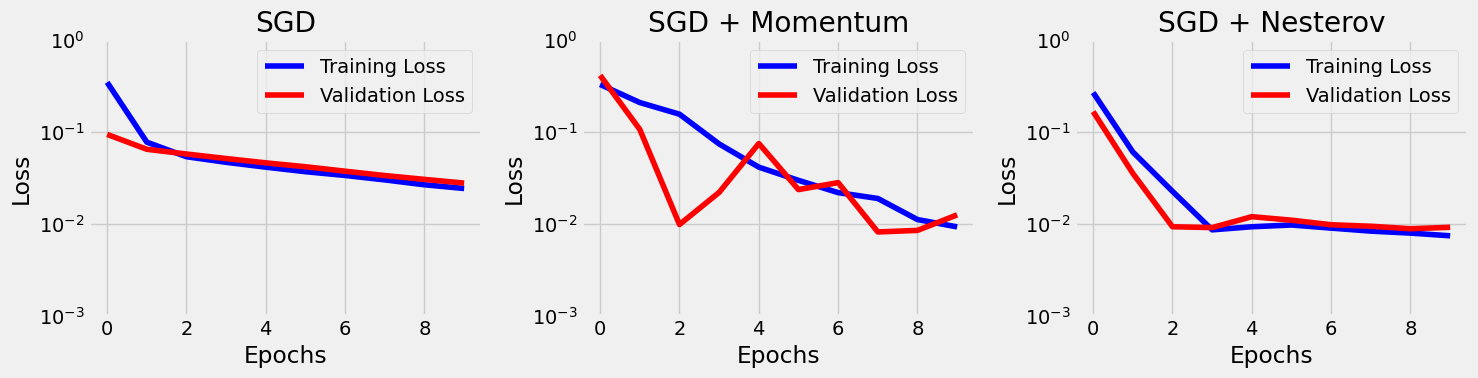

In [94]:
# Visualizando os resultados dos otimizadores
fig_losses = plot_losses(results)

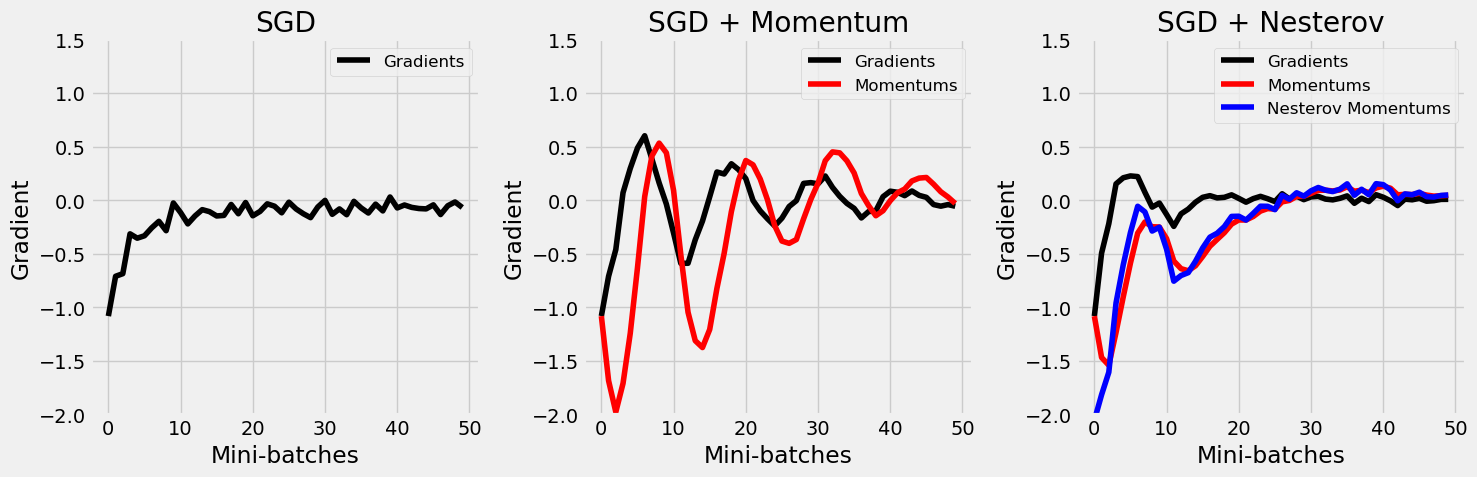

In [95]:
# Gerando um gráfico para representar os resultados
fig_21 = figure21(results)

# Learning Rate Schedulers

Também é possível agendar as mudanças na taxa de aprendizado à medida que o treinamento avança, em vez de adaptar os gradientes. Digamos que você gostaria de reduzir a taxa de aprendizado em uma ordem de magnitude (ou seja, multiplicá-la por 0,1) a cada T épocas, de modo que o treinamento seja mais rápido no começo e desacelere após um tempo para tentar evitar problemas de convergência.

É isso que um agendador de taxa de aprendizado faz: Ele atualiza a taxa de aprendizado do otimizador.

Portanto, não deve ser surpresa que um dos argumentos do agendador seja o próprio otimizador. A taxa de aprendizado definida para o otimizador será a taxa de aprendizado inicial do agendador. Como exemplo, vamos pegar o agendador mais simples: o StepLR, que simplesmente multiplica a taxa de aprendizado por um fator gamma a cada step_size épocas.

No código abaixo, criamos um otimizador fictício, que está "atualizando" um parâmetro falso com uma taxa de aprendizado inicial de 0,01. O agendador fictício, uma instância de StepLR, multiplicará essa taxa de aprendizado por 0,1 a cada duas épocas.

In [108]:
# Definindo o otimizador SGD com parâmetro dummy
dummy_optimizer = optim.SGD([nn.Parameter(torch.randn(1))], lr=0.01)

# Definindo o agendador StepLR que modifica a taxa de aprendizado a cada 2 épocas
dummy_scheduler = StepLR(dummy_optimizer, step_size=2, gamma=0.1)

O agendador tem um método step() assim como o otimizador. Você deve chamar o método step() do agendador depois de chamar o método step() do otimizador.

Dentro do loop de treinamento, ficará assim:

In [109]:
for epoch in range(4):
    # Loop de treinamento (o código real de treinamento deve ser adicionado aqui)
    
    # Exibe a última taxa de aprendizado
    print(dummy_scheduler.get_last_lr())
    
    # Primeiramente, realiza a atualização do otimizador
    dummy_optimizer.step()
    
    # Depois, realiza a atualização do agendador
    dummy_scheduler.step()
    
    # Zera os gradientes após a atualização
    dummy_optimizer.zero_grad()

[0.01]
[0.01]
[0.001]
[0.001]


Como esperado, manteve a taxa de aprendizado inicial por duas épocas e depois a multiplicou por 0,1, resultando em uma taxa de aprendizado de 0,001 por mais duas épocas. Em resumo, é assim que funciona um agendador de taxa de aprendizado.

"Todo agendador diminui a taxa de aprendizado?"

Na verdade, não. Antigamente, era procedimento padrão diminuir a taxa de aprendizado conforme você treinava o modelo, mas essa ideia foi desafiada pelas taxas de aprendizado cíclicas (isso é a parte "cíclica" do artigo de Leslie N. Smith!). Existem muitos tipos diferentes de agendadores, como você pode ver. E muitos deles estão disponíveis no PyTorch.

Estamos dividindo os agendadores em três grupos: agendadores que atualizam a taxa de aprendizado a cada T épocas (mesmo se T=1), como no exemplo acima; o agendador que só atualiza a taxa de aprendizado quando a perda de validação parece estar estagnada; e agendadores que atualizam a taxa de aprendizado após cada mini-batch.

## Epoch Schedulers

Esses agendadores terão seu método step() chamado ao final de cada época. Mas cada agendador tem suas próprias regras para atualizar a taxa de aprendizado.

* StepLR: Multiplica a taxa de aprendizado por um fator gamma a cada step_size épocas.
  
* MultiStepLR: Multiplica a taxa de aprendizado por um fator gamma nas épocas indicadas na lista de marcos.
  
* ExponentialLR: Multiplica a taxa de aprendizado por um fator gamma a cada época, sem exceções.
  
* LambdaLR: Recebe sua própria função personalizada que deve receber a época como argumento e retornar o fator multiplicativo correspondente (em relação à taxa de aprendizado inicial).
  
* CosineAnnealingLR: Usa uma técnica chamada cosine annealing para atualizar a taxa de aprendizado, mas não vamos entrar em detalhes aqui.

  
Podemos usar o LambdaLR para imitar o comportamento do agendador StepLR definido acima:

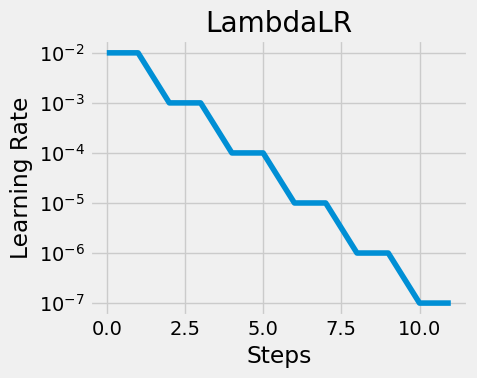

In [110]:
# Definindo o otimizador SGD
dummy_optimizer = optim.SGD([nn.Parameter(torch.randn(1))], lr=0.01)

# Usando LambdaLR que ajusta a taxa de aprendizado com base na época
dummy_scheduler = LambdaLR(dummy_optimizer, lr_lambda=lambda epoch: 0.1 ** (epoch//2))

# Alternativamente, poderia ser usado um StepLR equivalente:
# dummy_scheduler = StepLR(dummy_optimizer, step_size=2, gamma=0.1)

# Exibe o gráfico de mudanças de taxa de aprendizado
fig = plot_scheduler(dummy_optimizer, dummy_scheduler)

## Validation Loss Scheduler

O agendador ReduceLROnPlateau também deve ter seu método step() chamado ao final de cada época, mas ele tem seu próprio grupo aqui porque não segue um agendamento pré-definido. Irônico, né?

O método step() recebe a perda de validação como argumento, e o agendador pode ser configurado para tolerar a falta de melhoria na perda (até um limite, é claro) por um número específico de épocas (o argumento chamado patience).

Depois que o agendador perde a paciência, ele atualiza a taxa de aprendizado, multiplicando-a pelo argumento factor (para os agendadores listados na seção anterior, esse fator foi chamado de gamma).

Para ilustrar seu comportamento, vamos supor que a perda de validação permaneça no mesmo valor (seja lá qual for) por 12 épocas consecutivas. O que nosso agendador faria?

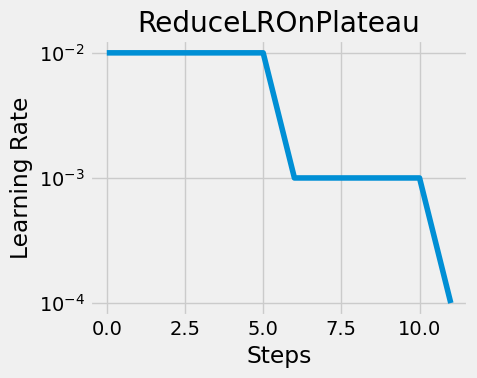

In [111]:
# Definindo o otimizador SGD
dummy_optimizer = optim.SGD([nn.Parameter(torch.randn(1))], lr=0.01)

# Usando ReduceLROnPlateau que reduz a taxa de aprendizado se a perda de validação não melhorar
dummy_scheduler = ReduceLROnPlateau(dummy_optimizer, patience=4, factor=0.1)

# Exibe o gráfico de mudanças de taxa de aprendizado
fig = plot_scheduler(dummy_optimizer, dummy_scheduler)

Sua paciência é de quatro épocas, então após quatro épocas observando a mesma perda, ele está por um fio. Então vem a quinta época sem mudança: "Chega, a taxa de aprendizado precisa cair" :-) Então, na sexta época, o otimizador já está usando a taxa de aprendizado atualizada. Se nada mudar por mais quatro épocas, ela diminuirá novamente, como mostrado na figura acima.


## Alterações na Classe Architecture

In [112]:
# Adicionando a função _epoch_schedulers à classe Architecture
def _epoch_schedulers(self, val_loss):
    if self.scheduler:
        if not self.is_batch_lr_scheduler:
            # Atualiza o agendador
            if isinstance(self.scheduler, torch.optim.lr_scheduler.ReduceLROnPlateau):
                self.scheduler.step(val_loss)
            else:
                self.scheduler.step()

            # Armazena a taxa de aprendizado atual
            current_lr = list(map(lambda d: d['lr'], self.scheduler.optimizer.state_dict()['param_groups']))
            self.learning_rates.append(current_lr)

setattr(Architecture, '_epoch_schedulers', _epoch_schedulers)

In [113]:
def train(self, n_epochs, seed=42):
    # Garantir reprodutibilidade do processo de treinamento
    self.set_seed(seed)

    for epoch in range(n_epochs):
        # Incrementa o número total de épocas
        self.total_epochs += 1

        # Realiza o treinamento usando mini-lotes
        loss = self._mini_batch(validation=False)
        self.losses.append(loss)

        # Validação (sem cálculo de gradientes)
        with torch.no_grad():
            val_loss = self._mini_batch(validation=True)
            self.val_losses.append(val_loss)

        # Atualiza o agendador com a perda de validação
        self._epoch_schedulers(val_loss)

        # Se um SummaryWriter foi configurado, registra os dados
        if self.writer:
            scalars = {'training': loss}
            if val_loss is not None:
                scalars.update({'validation': val_loss})
            self.writer.add_scalars(main_tag='loss', tag_scalar_dict=scalars, global_step=epoch)

    if self.writer:
        self.writer.close()

setattr(Architecture, 'train', train)

## Mini-Batch Schedulers

Esses agendadores têm seu método step() chamado ao final de cada mini-batch. Todos eles são agendadores cíclicos.


* CyclicLR: Cicla entre base_lr e max_lr (desconsiderando a taxa de aprendizado inicial definida no otimizador), usando step_size_up atualizações para ir de base para max taxa de aprendizado, e step_size_down atualizações para voltar. Esse comportamento corresponde a mode=triangular. Além disso, é possível diminuir a amplitude usando diferentes modos: triangular2 vai reduzir pela metade a amplitude após cada ciclo, enquanto exp_range diminuirá exponencialmente a amplitude usando gamma como base e o número do ciclo como expoente.
Uma escolha típica para max_lr é a taxa de aprendizado encontrada usando o LR Range Test.


* OneCycleLR: Usa um método chamado annealing para atualizar a taxa de aprendizado de seu valor inicial até uma taxa de aprendizado máxima definida (max_lr) e depois até uma taxa de aprendizado muito mais baixa ao longo de um número de atualizações (total_steps), realizando assim um único ciclo.

  
* CosineAnnealingWarmRestarts: Usa cosine annealing para atualizar a taxa de aprendizado, mas não vamos entrar em detalhes aqui, exceto para dizer que esse agendador requer o número da época (incluindo a parte fracionária correspondente ao número de mini-batches ao longo do tamanho do data loader) como argumento de seu método step().

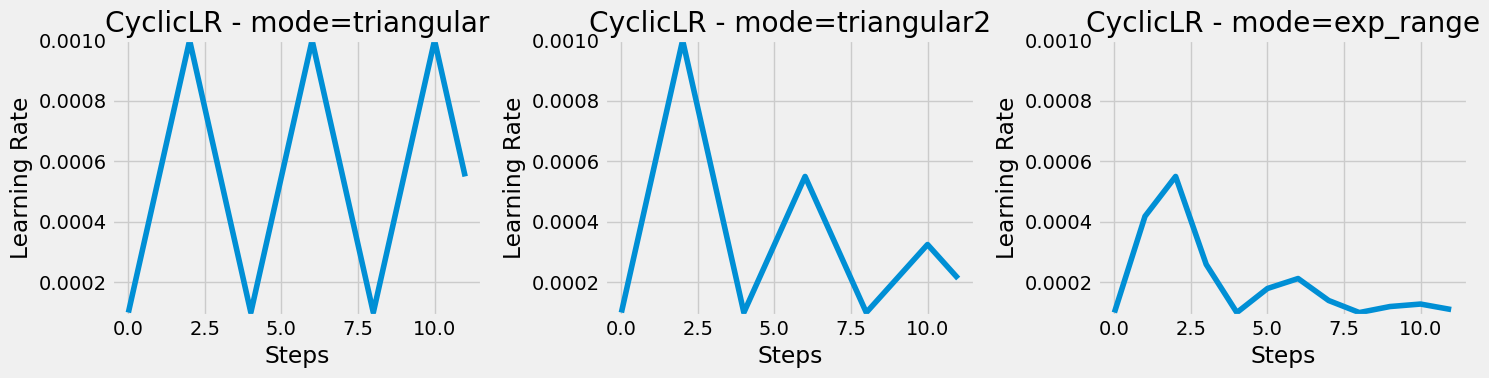

In [114]:
dummy_optimizer = optim.SGD(dummy_parm, lr=0.01)

# Definindo três tipos de agendadores de ciclo
dummy_scheduler1 = CyclicLR(dummy_optimizer, base_lr=1e-4, max_lr=1e-3, step_size_up=2, mode='triangular')
dummy_scheduler2 = CyclicLR(dummy_optimizer, base_lr=1e-4, max_lr=1e-3, step_size_up=2, mode='triangular2')
dummy_scheduler3 = CyclicLR(dummy_optimizer, base_lr=1e-4, max_lr=1e-3, step_size_up=2, mode='exp_range', gamma=np.sqrt(0.5))

# Exibe os gráficos de mudança de taxa de aprendizado
fig = figure26(dummy_optimizer, (dummy_scheduler1, dummy_scheduler2, dummy_scheduler3))

In [115]:
# Função que aplica agendadores para mini-batches
def _mini_batch_schedulers(self, frac_epoch):
    if self.scheduler:
        if self.is_batch_lr_scheduler:
            # Atualiza o agendador a cada mini-lote
            if isinstance(self.scheduler, torch.optim.lr_scheduler.CosineAnnealingWarmRestarts):
                self.scheduler.step(self.total_epochs + frac_epoch)
            else:
                self.scheduler.step()

            # Armazena a taxa de aprendizado atual
            current_lr = list(map(lambda d: d['lr'], self.scheduler.optimizer.state_dict()['param_groups']))
            self.learning_rates.append(current_lr)

setattr(Architecture, '_mini_batch_schedulers', _mini_batch_schedulers)

In [116]:
# Função que realiza o processamento dos mini-lotes
def _mini_batch(self, validation=False):
    if validation:
        data_loader = self.val_loader
        step_fn = self.val_step_fn
    else:
        data_loader = self.train_loader
        step_fn = self.train_step_fn

    if data_loader is None:
        return None

    n_batches = len(data_loader)
    mini_batch_losses = []
    for i, (x_batch, y_batch) in enumerate(data_loader):
        x_batch = x_batch.to(self.device)
        y_batch = y_batch.to(self.device)

        mini_batch_loss = step_fn(x_batch, y_batch)
        mini_batch_losses.append(mini_batch_loss)

        if not validation:
            self._mini_batch_schedulers(i / n_batches)

    loss = np.mean(mini_batch_losses)
    return loss

setattr(Architecture, '_mini_batch', _mini_batch)

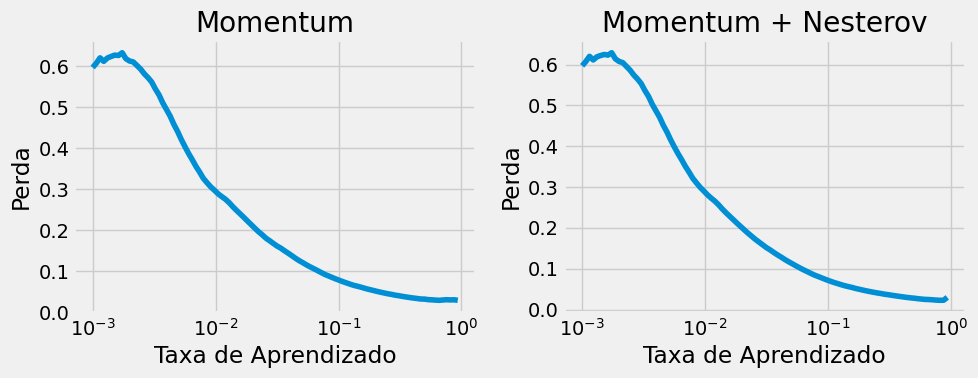

In [117]:
# Exemplo de visualização da taxa de aprendizado durante o treinamento
fig, axs = plt.subplots(1, 2, figsize=(10, 4))
for ax, nesterov in zip(axs.flat, [False, True]):
    torch.manual_seed(42)
    model = nn.Sequential()
    model.add_module('linear', nn.Linear(1, 1))
    loss_fn = nn.MSELoss(reduction='mean')
    optimizer = optim.SGD(model.parameters(), lr=1e-3, momentum=0.9, nesterov=nesterov)

    sbs_scheduler = Architecture(model, loss_fn, optimizer)
    tracking, fig = sbs_scheduler.lr_range_test(train_loader, end_lr=1, num_iter=100, ax=ax)
    
    nest = ' + Nesterov' if nesterov else ''
    ax.set_title(f'Momentum{nest}')

In [128]:
step_scheduler = StepLR(optimizer, step_size=20, gamma=0.5)
cyclic_scheduler = CyclicLR(optimizer, base_lr=0.025, max_lr=0.1, step_size_up=10, mode='triangular2')

In [129]:
# Generating data for the plots
torch.manual_seed(42)
model = nn.Sequential()
model.add_module('linear', nn.Linear(1, 1))
loss_fn = nn.MSELoss(reduction='mean')

optimizers = {'SGD + Momentum': {'class': optim.SGD, 'parms': {'lr': 0.1, 'momentum': 0.9}},
              'SGD + Momentum + Step': {'class': optim.SGD, 'parms': {'lr': 0.1, 'momentum': 0.9}},
              'SGD + Momentum + Cycle': {'class': optim.SGD, 'parms': {'lr': 0.1, 'momentum': 0.9}},
              'SGD + Nesterov': {'class': optim.SGD, 'parms': {'lr': 0.1, 'momentum': 0.9, 'nesterov': True}},
              'SGD + Nesterov + Step': {'class': optim.SGD, 'parms': {'lr': 0.1, 'momentum': 0.9, 'nesterov': True}},
              'SGD + Nesterov + Cycle': {'class': optim.SGD, 'parms': {'lr': 0.1, 'momentum': 0.9, 'nesterov': True}}}

schedulers = {'SGD + Momentum + Step': {'class': StepLR, 'parms': {'step_size': 4, 'gamma': 0.5}},
              'SGD + Momentum + Cycle': {'class': CyclicLR, 'parms': {'base_lr': 0.025, 'max_lr': 0.1, 'step_size_up': 10, 'mode': 'triangular2'}},
              'SGD + Nesterov + Step': {'class': StepLR, 'parms': {'step_size': 4, 'gamma': 0.5}},
              'SGD + Nesterov + Cycle': {'class': CyclicLR, 'parms': {'base_lr': 0.025, 'max_lr': 0.1, 'step_size_up': 10, 'mode': 'triangular2'}}}

results = compare_optimizers(model, loss_fn, optimizers, train_loader, val_loader, schedulers, n_epochs=10)

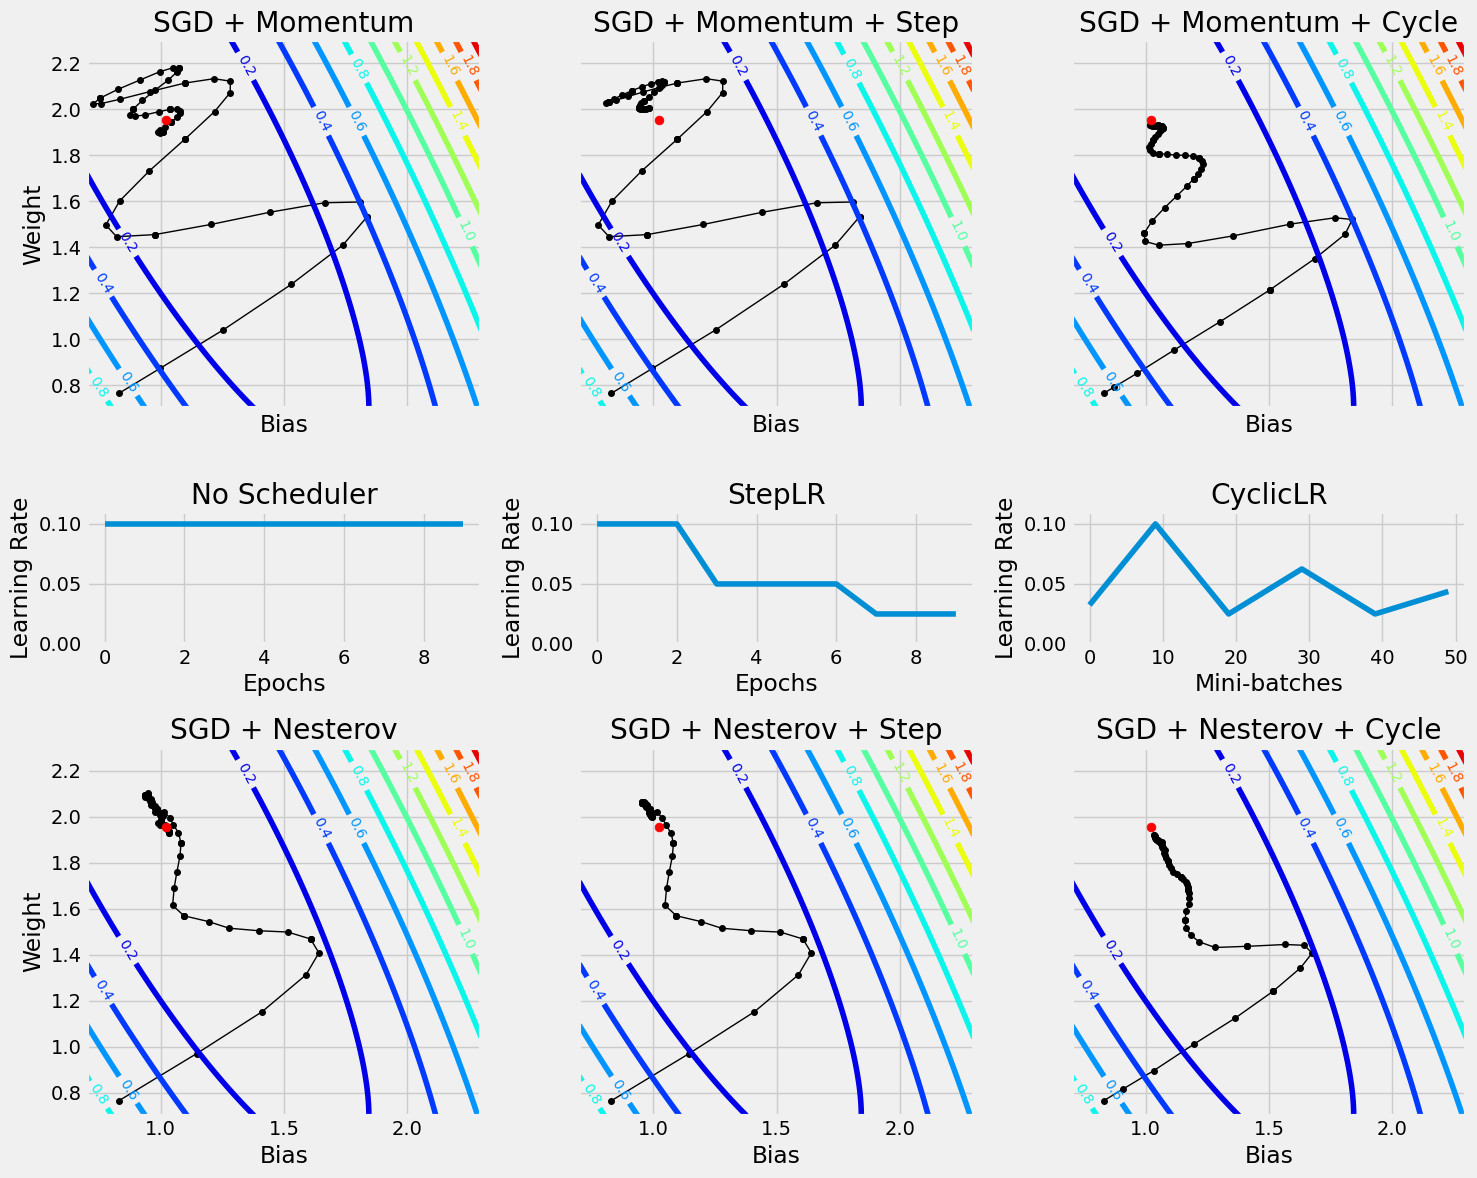

In [130]:
fig = figure28(results, b, w, bs, ws, all_losses)

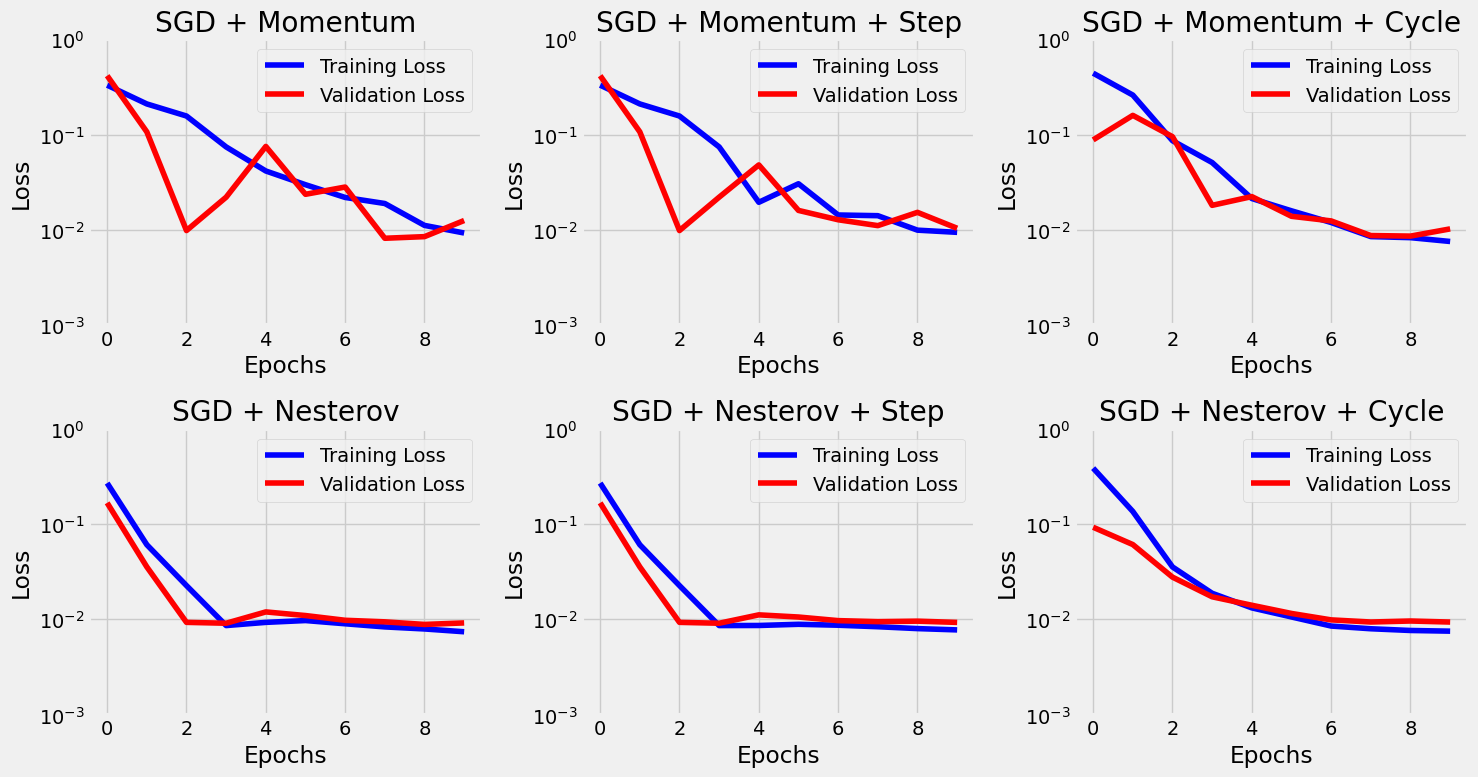

In [131]:
fig, axs = plt.subplots(2, 3, figsize=(15, 8))
axs = axs.flat
fig = plot_losses(results, axs)

# Hora da prática

Vamos integrar todos os conceitos que vimos: EWMA, adam, SDG e learning rate schedulers.


O primeiro passo é escolher nosso dataset. Se queremos um exemplo de CNN simples, nada melhor do que usar o MNIST, um dos datasets mais usados para exemplos de visão computacional.


O MNIST é um grande conjunto de dados (treinamento com 60.000 exemplos e um conjunto de teste com 10.000 exemplos) de dígitos manuscritos. Os dígitos foram normalizados em termos de tamanho e centralizados em uma imagem de tamanho fixo.

Vamos utilizar o DataLoader e uma normalização baseada em estatísticas do dataset:

In [122]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])
trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

O nosso próximo passo é a inicialização do nosso modelo. Como o foco desta seção é mostra o uso das ferramentas, vamos aplicar uma arquitetura bem simples.

In [123]:
class SimpleNN(nn.Module):
    def __init__(self):
        super(SimpleNN, self).__init__()
        self.model = nn.Sequential(
            nn.Flatten(),
            nn.Linear(28 * 28, 128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, 10)
        )
    def forward(self, x):
        return self.model(x)

Agora vamos para o que interessa! Vamos definir o Adam e o SGD para comparação e incluir um scheduler da nossa escolha (aqui dá para brincar e testar todos que estudamos).

In [124]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SimpleNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = StepLR(optimizer, step_size=5, gamma=0.5)

Não podemos esquecer da suavização dos gradientes com EWMA.


In [125]:
def ewma(values, alpha=0.2):
    result = []
    avg = values[0]
    for val in values:
        avg = alpha * val + (1 - alpha) * avg
        result.append(avg)
    return result

Agora vamos treinar nosso modelo e obter nossas acurácias para cada época.

In [126]:
num_epochs = 20
train_loss = []
train_acc = []
lrs = []
gradients = []

In [127]:
for epoch in range(num_epochs):
    correct = 0
    total = 0
    running_loss = 0.0
    for inputs, labels in trainloader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        grad_norm = sum(p.grad.abs().mean().item() for p in model.parameters())
        gradients.append(grad_norm)

        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    scheduler.step()
    train_loss.append(running_loss / len(trainloader))
    train_acc.append(100 * correct / total)
    lrs.append(optimizer.param_groups[0]['lr'])

Bom, com isso já temos um modelo — mesmo que simples — em pleno funcionamento! Vamos ver como ele ele foi na prática?

Primeiro, vamos ver nossa curva de acurácia!

Text(0.5, 1.0, 'Acurácia (%)')

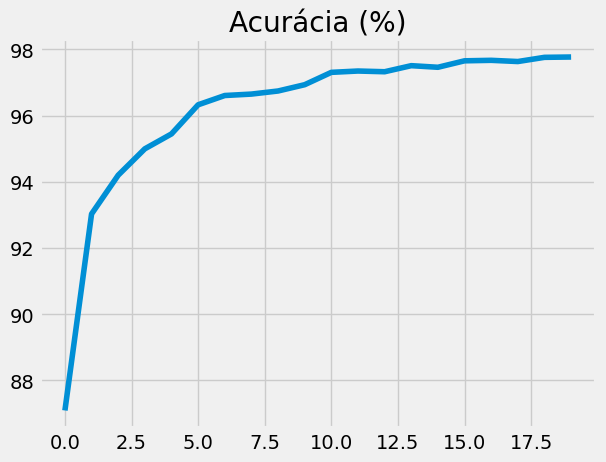

In [128]:
plt.plot(train_acc, label='Train Accuracy')
plt.title('Acurácia (%)')

Para um modelo simples, os resultados foram bem bacanas! 97,42% de acurácia no treinamento :)

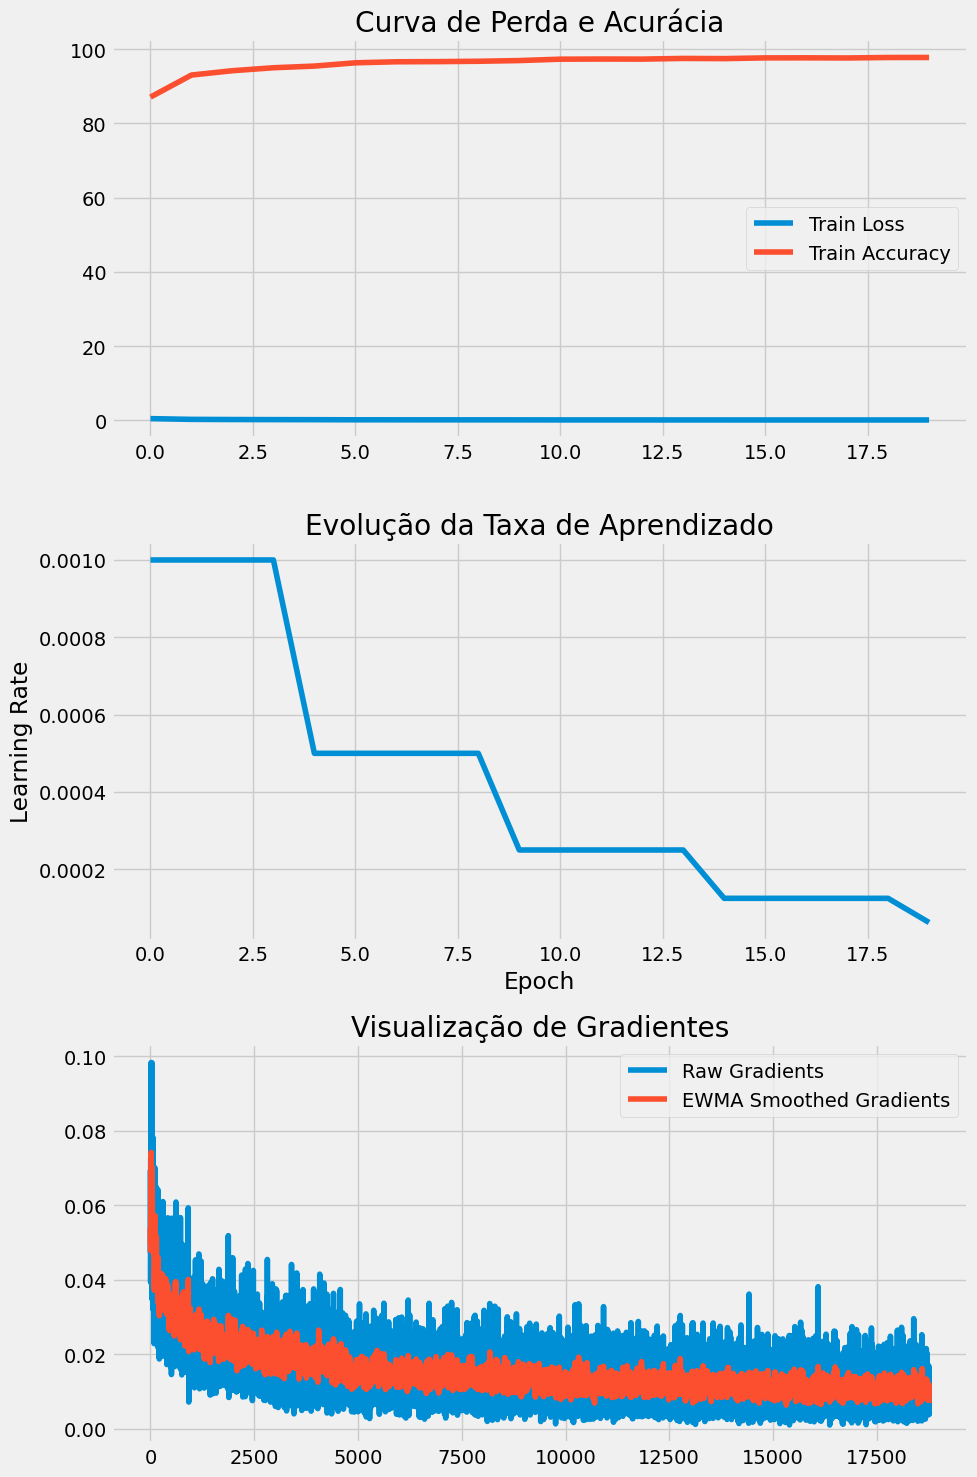

In [129]:
fig, axs = plt.subplots(3, 1, figsize=(10, 15))


axs[0].plot(train_loss, label='Train Loss')
axs[0].plot(train_acc, label='Train Accuracy')
axs[0].set_title('Curva de Perda e Acurácia')
axs[0].legend()

axs[1].plot(lrs)
axs[1].set_title('Evolução da Taxa de Aprendizado')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Learning Rate')

smoothed_gradients = ewma(gradients)
axs[2].plot(gradients, label='Raw Gradients')
axs[2].plot(smoothed_gradients, label='EWMA Smoothed Gradients')
axs[2].set_title('Visualização de Gradientes')
axs[2].legend()

plt.tight_layout()
plt.show()

A gente consegue ver que a taxa de aprendizado começa relativamente alta e decresce em etapas ao longo das épocas. Isso se deve ao scheduler escolhido, que reduz a taxa de aprendizado progressivamente, o que pode ajudar o modelo a refinar os pesos ao longo do treinamento, prevenindo oscilações excessivas no final. Podemos testar outros tipos de schedulers para comparar seu comportamento. Legal, né?


Inicialmente, os gradientes são elevados, mas reduzem com o tempo, indicando que o modelo está se ajustando e atualizando os pesos de forma mais sutil ao longo do tempo. A curva suavizada mostra uma diminuição mais estável dos gradientes, o que sugere um processo de convergência controlado, do jeito que a gente queria 🥳🪩.
